# 2017_03_09 Data observation : from the raw data

- Reanalysis using
    - ```Freesurfer brain.mgz <--> Diffusion space```
    
    (It was `brain.mgz <--> co.nii.gz <--> diffusion space` in the previous version)

---

### Import libraries

In [1]:
import pandas as pd
import os
import re
import numpy as np
import nibabel
import argparse
import textwrap
import time
from multiprocessing import Pool
from numpy import count_nonzero
import statsmodels
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats

%matplotlib inline

In [2]:
pd.set_option('max_columns',5000)

In [3]:
pwd

'/Users/kangik/Dropbox/project/2017_CHR_thalamic_nuclei/script'

In [2]:
cortices = ["LPFC","LTC","MPFC",
            "MTC","OFC","PC","SMC",'OCC']

In [5]:
dataLoc = '/Volume/CCNC_W1_2T/2017_CHR_thalamus_microstructure_kcho/allData'
subjects = [x for x in os.listdir(dataLoc) \
                if x.startswith('NOR') or x.startswith('CHR')]

    !tree -n -L 2 $dataLoc/CHR13_KBK

# 0. loading the data from image files

In [3]:
def get_map(f):
    '''
    Load nifti file and return the data matrix of the image file
    '''
    return nibabel.load(f).get_data()

In [11]:
class thalamus:
    def __init__(self, param):
        # Expand from the input tuple
        dataLoc, subject = param
        
        subjDir = os.path.join(dataLoc, subject)
        roiDir = os.path.join(subject, 'ROI')
        
        dkiDir = os.path.join(subject, 'DKI')
        dtiDir = os.path.jon(subject, 'DTI')

        df = pd.DataFrame()
        for side_s in 'lh', 'rh':
            
            # define side variables 
            if side_s=='lh':
                side = 'left'
            else:
                side = 'right'

            segDir = os.path.join(subject, 'segmentation', side)
            
            # MK file in original diffusion space
            mk_file = os.path.join(dkiDir, 'kmean.nii')
            mk_map = get_map(mk_file)

            # Thalamus ROI in Freesurfer space
            # Save the volume of the thalamus in self.thalamus_vol
            thalamus_file = os.path.join(roiDir, '{0}_thalamus.nii.gz'.format(side_s[0]))
            thalamus_map = get_map(thalamus_file)
            thalamus_vol = count_nonzero(thalamus_map)

            
            
            for cortex in cortices:
                # seeds file in T1 space    
                seeds_in_raw = os.path.join(segDir, 'seeds_to_{side_s}_{cortex}.nii.gz'.format(
                        side_s=side_s, cortex=cortex))
                seeds_in_raw_map = get_map(seeds_in_raw)
                total_connectivity_raw = sum(seeds_in_raw_map[seeds_in_raw_map != 0])
                
                # Cortical roi in Freesurfer space
                cortical_roi = os.path.join(roiDir, '{side}_{cortex}.nii.gz'.format(
                        side=side_s, cortex=cortex))
                cortex_map = get_map(cortical_roi)
                cortical_roi_vol = count_nonzero(cortex_map)

                for threshold in ['5', '10', '20', '90', '95']:
                    thrDir = os.path.join(segDir, threshold+'thrP')
                    # seeds file in DKI space
                    seeds_in_dki = os.path.join(thrDir, 
                                                '{threshold}_seeds_to_{side_s}_{cortex}.nii.gz'.format(
                            side_s=side_s, cortex=cortex, threshold=threshold))        
                    seeds_in_dki_map = get_map(seeds_in_dki)
                    thal_seg_volume = count_nonzero(seeds_in_dki_map)
                    thal_seg_mk = np.mean(mk_map[(seeds_in_dki_map > 0) & (mk_map != 0)])

                    df = pd.concat([
                                    df,
                                    pd.DataFrame([[subject, side, cortex, wujeong_threshold, 
                                                   cortical_roi_vol, 
                                                   thalamus_vol, thal_seg_volume, thal_seg_mk,
                                                   total_connectivity,
                                                   total_connectivity_raw]],
                                                 columns = ['subject','side','cortex','threshold',
                                                            'cortex_volume', 'thalamus_volume', 
                                                            'thalamus_seg_volume', 'thalamus_seg_mk',
                                                            'total_connectivity',
                                                            'total_connectivity_raw']),
                               ])
        self.df = df.reset_index().drop('index', axis=1)

In [12]:
f = subject_wujeong((dataLoc, subjects[0]))

In [14]:
# ```
subjects = [x for x in os.listdir(dataLoc) \
                if x.startswith('NOR') or x.startswith('CHR')]
# DKI/kmean.nii is not missing in NOR73_KMS (kmean2.nii existed)
# subjects.remove('NOR73_KMS')

thresholds = [10, 90, 95]
sides = ['lh', 'rh']
cortex = ['LPFC', 'LTC', 'MPFC', 'MTC', 'OCC', 'OFC', 'PC', 'SMC']
# a = [[dataLoc], subjects, sides, cortex, thresholds]
a = [[dataLoc], subjects]
all_combinations = list(itertools.product(*a))
pool = Pool()
outs = pool.map(subject_wujeong, all_combinations)
merged_df = pd.concat([x.df for x in outs])
merged_df.to_csv('/home/kangik/Dropbox/project/2017_CHR_thalamic_nuclei/script/all_data_from_wujeong_raw.csv')
# ```

/home/kangik/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


# 1. Data rearrange

### Load data

```
allData = pd.read_csv('/home/kangik/Dropbox/project/2017_CHR_thalamic_nuclei/script/all_data_from_wujeong_raw.csv',
                       index_col=0)
allData['threshold'] = allData['threshold'].str[-2:]
allData['group'] = allData['subject'].str[:3]
```

```
allData.head()
```

```
total_connectivity_sum = allData.groupby(['threshold', 'subject', 'side']).sum().reset_index()[['subject','side','total_connectivity_raw']]
total_connectivity_sum.columns = ['subject','side','total_connectivity_raw_sum']
allData = pd.merge(allData,
                  total_connectivity_sum,
                  on=['subject','side'],
                  how='inner')
```

In [105]:
total_connectivity_10 = allData.groupby(['threshold', 'subject', 'side']).sum().reset_index()[['subject', 'side', 'total_connectivity']]
total_connectivity_10.columns = ['subject', 'side', 'total_connectivity_10']
total_connectivity_10['threshold'] = '10'
allData = pd.merge(allData,
                  total_connectivity_10,
                  on=['subject','side', 'threshold'],
                  how='left')
allData = allData.drop_duplicates()

allData['relative_connectivity'] = allData.total_connectivity_raw / allData.total_connectivity_raw_sum

### Number of subjects in each group

In [104]:
allData = pd.read_csv('/Users/kangik/Dropbox/project/2017_CHR_thalamic_nuclei/script/all_data_from_wujeong_raw.csv',
                       index_col=0)

In [114]:
allData.groupby(['group','side','cortex','threshold']).count()[['subject']]

subject
group side  cortex threshold         
CHR   left  LPFC   10              91
                   90              91
                   95              91
            LTC    10              91
                   90              91
                   95              91
            MPFC   10              91
                   90              91
                   95              91
            MTC    10              91
                   90              91
                   95              91
            OCC    10              91
                   90              91
                   95              91
            OFC    10              91
                   90              91
                   95              91
            PC     10              91
                   90              91
                   95              91
            SMC    10              91
                   90              91
                   95              91
      right LPFC   10              91
                   90              91
                   95              91
            LTC    10              91
                   90              91
                   95              91
...                               ...
NOR   left  PC     10             100
                   90             100
                   95             100
            SMC    10             100
                   90             100
                   95             100
      right LPFC   10             100
                   90             100
                   95             100
            LTC    10             100
                   90             100
                   95             100
            MPFC   10             100
                   90             100
                   95             100
            MTC    10             100
                   90             100
                   95             100
            OCC    10             100
                   90             100
                   95             100
            OFC    10             100
                   90             100
                   95             100
            PC     10             100
                   90             100
                   95             100
            SMC    10             100
                   90             100
                   95             100

[96 rows x 1 columns]

`
allData.drop_duplicates().to_csv('/home/kangik/Dropbox/project/2017_CHR_thalamic_nuclei/script/all_data_from_wujeong_raw.csv')
`

### Load matched group list

In [9]:
f = pd.ExcelFile('CHR_NOR_match_20160831.xlsx')
data_locking_df = f.parse(0)

In [10]:
data_locking_df.columns

Index(['koreanName', 'subjectName', 'subjectInitial', 'group', 'sex', 'age',
       'handedness', 'DOB', 'scanDate', 'timeline', 'studyname',
       'patientNumber', 'T1Number', 'DTINumber', 'DKINumber', 'RESTNumber',
       'REST2Number', 'folderName', 'backUpBy', 'note', 'Unnamed: 20'],
      dtype='object')

> Are there only baseline files ?

In [11]:
data_locking_df.timeline.unique()

array(['baseline'], dtype=object)

### Extracting the matched set data

> List of subjects 

- only in the matched set 
- but not in the data set

In [63]:
[x for x in data_locking_df.folderName if x not in allData.subject.unique()]

['CHR02_JHJ', 'CHR32_CWJ', 'CHR36_KJH']

In [64]:
len(allData.subject.unique())

191

In [65]:
len(data_locking_df.folderName.unique())

157

In [66]:
df_matched = pd.merge(allData,
                      data_locking_df[['folderName','sex','age','handedness','DKINumber','note']],
                      left_on='subject',
                      right_on='folderName',
                      how='inner')

In [67]:
df_matched[['group','subject']].drop_duplicates().groupby('group').count()

,subject
group,
CHR,76
NOR,78


### NOR (78) vs CHR (76)

----

# 2. Data exploration

In [68]:
df_matched.columns

Index(['subject', 'side', 'cortex', 'threshold', 'cortex_volume',
       'thalamus_volume', 'thalamus_seg_volume', 'thalamus_seg_mk',
       'total_connectivity', 'total_connectivity_raw', 'group',
       'total_connectivity_raw_sum', 'relative_connectivity', 'folderName',
       'sex', 'age', 'handedness', 'DKINumber', 'note'],
      dtype='object')

In [69]:
df_matched = df_matched[[u'subject',                u'side',              u'cortex',
                 u'threshold',       u'cortex_volume',     u'thalamus_volume',
       u'thalamus_seg_volume',     u'thalamus_seg_mk',  u'total_connectivity', 
                         u'total_connectivity_raw', u'relative_connectivity',
                     u'group',          u'folderName',                 u'sex',
                       u'age',          u'handedness']]

In [70]:
df_matched.describe()

/Users/kangik/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,threshold,cortex_volume,thalamus_volume,thalamus_seg_volume,thalamus_seg_mk,total_connectivity,total_connectivity_raw,relative_connectivity,sex,age,handedness
count,7392.000000,7392.000000,7392.000000,7392.00000,7391.000000,7.392000e+03,7.392000e+03,7392.000000,7392.000000,7392.000000,7392.000000
mean,65.000000,32180.259740,8844.792208,90.59862,0.949597,2.144043e+05,1.497620e+06,0.125000,1.305195,21.714286,1.077922
std,38.947039,14532.539289,930.592341,113.08365,0.144744,2.553183e+05,1.206920e+06,0.090638,0.460521,3.364892,0.268067
min,10.000000,11214.000000,6677.000000,0.00000,0.349874,0.000000e+00,6.123000e+03,0.001154,1.000000,17.000000,1.000000
25%,10.000000,19830.250000,8251.500000,18.00000,NaN,5.170750e+03,5.300375e+05,0.045279,1.000000,19.000000,1.000000
50%,90.000000,29192.000000,8762.000000,24.00000,NaN,1.246295e+05,1.259638e+06,0.109851,1.000000,21.000000,1.000000
75%,95.000000,40524.750000,9362.250000,169.00000,NaN,3.533368e+05,2.184339e+06,0.183538,2.000000,24.000000,1.000000
max,95.000000,79156.000000,12415.000000,662.00000,1.552329,2.953814e+06,1.445700e+07,0.540372,2.000000,34.000000,2.000000


In [ ]:
df_matched[df_matched.isnull().any(axis=1)]

In [ ]:
df_matched[df_matched.thalamus_seg_volume==0]

In [ ]:
df_matched[(df_matched.subject=='NOR80_CHM') & (df_matched.cortex=='OCC') & (df_matched.side=='right')]

> foward fill the missing data

In [74]:
df_matched.loc[df_matched.thalamus_seg_volume==0, 'thalamus_seg_volume'] = 0

In [75]:
df_matched.thalamus_seg_mk = df_matched.thalamus_seg_mk.fillna(method='ffill')

> Recheck

In [76]:
df_matched[df_matched.isnull().any(axis=1)]

,subject,side,cortex,threshold,cortex_volume,thalamus_volume,thalamus_seg_volume,thalamus_seg_mk,total_connectivity,total_connectivity_raw,relative_connectivity,group,folderName,sex,age,handedness


In [77]:
df_matched.to_csv('all_data_from_wujeong_raw_matched.csv')

In [78]:
df_matched.threshold = df_matched.threshold.astype('str')

# Graphs

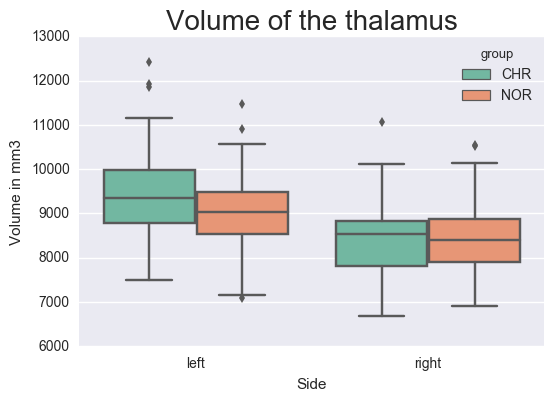

In [26]:
sns.boxplot('side','thalamus_volume', 
            hue='group', 
            palette=sns.color_palette("Set2", 2), 
            data=df_matched[['side','thalamus_volume','group']].drop_duplicates())
plt.title('Volume of the thalamus', fontsize=20)
plt.ylabel('Volume in mm3')
plt.xlabel('Side')
plt.show()

/Users/kangik/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


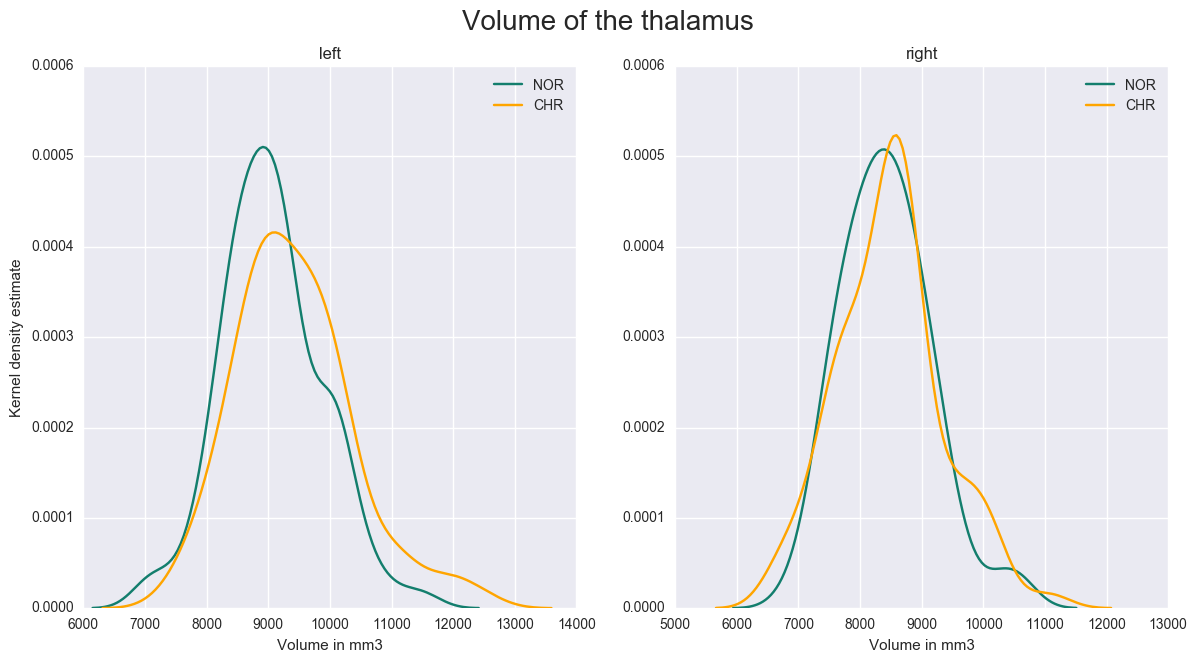

In [27]:
gb = df_matched[['side','thalamus_volume','group']].drop_duplicates().groupby(['group','side'])
var = 'thalamus_volume'

fig, axes = plt.subplots(ncols=2, figsize=(14,7))
for num, side in enumerate(['left','right']):
    sns.kdeplot(gb.get_group(('NOR',side))[var], label='NOR', ax=axes[num], color=sns.xkcd_rgb['blue green'])
    sns.kdeplot(gb.get_group(('CHR',side))[var], label='CHR', ax=axes[num], color='orange')
    axes[num].set_title(side)
    axes[num].set_xlabel('Volume in mm3')

fig.suptitle('Volume of the thalamus', fontsize=20)
axes[0].set_ylabel('Kernel density estimate')

plt.show()

             df        sum_sq       mean_sq         F    PR(>F)
GROUP       1.0  4.851624e+06  4.851624e+06  6.356798  0.012738
AGE         1.0  5.269816e+05  5.269816e+05  0.690473  0.407324
SEX         1.0  4.126885e+06  4.126885e+06  5.407216  0.021394
Residual  150.0  1.144827e+08  7.632182e+05       NaN       NaN


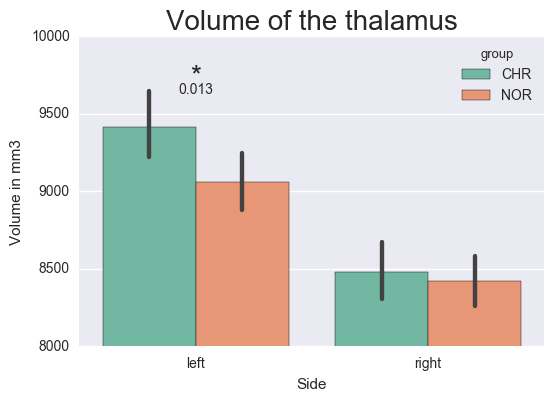

In [28]:
df = df_matched[['subject',
                 'side',
                 'thalamus_volume',
                 'age',
                 'sex',
                 'group']].drop_duplicates()

ax = sns.barplot('side','thalamus_volume', 
                 hue = 'group', 
                 palette = sns.color_palette("Set2", 2), 
                 data = df)
ax.set_title('Volume of the thalamus', fontsize=20)
ax.set_ylabel('Volume in mm3')
ax.set_ylim(8000, 10000)
ax.set_xlabel('Side')

compare = 'thalamus_volume'

for num, side in enumerate(['left', 'right']):
    x = df.groupby('side').get_group(side)
    GROUP = x['group']
    VAR = x[compare]
    AGE = x['age']
    SEX = x['sex']
    
    formula = 'VAR ~ GROUP + AGE + SEX'
    lm = ols(formula, x).fit()
    output = anova_lm(lm)
    if output['PR(>F)'].GROUP < 0.05:
        print(output)
        gb = x.groupby('group')
        
        if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
            group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
            group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
        else:
            group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
            group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

        ax.annotate("*", 
                    xy=(num, group_mean_upper+group_std_upper/3), 
                    va='center', ha='center', fontsize=20)
        ax.annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                    xy=(num, group_mean_upper+group_std_upper/4), 
                    va='center', ha='center', fontsize=10)
        
plt.show()

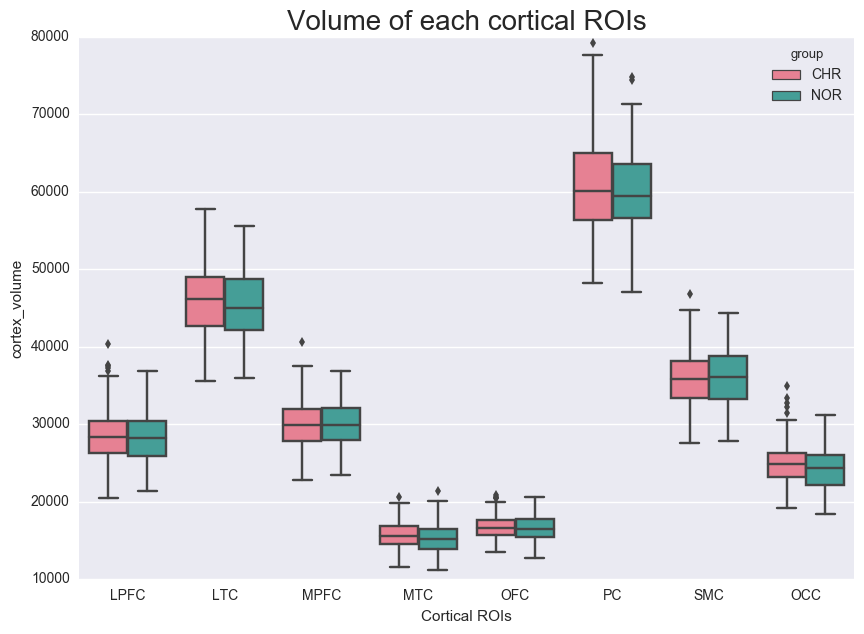

In [29]:
ax = plt.figure(figsize=(10,7))
ax = sns.boxplot('cortex','cortex_volume', 
                 hue='group', 
                 palette=sns.color_palette("husl",2),
                 data=df_matched[['subject', 'cortex','cortex_volume','group']].drop_duplicates())
ax.set_title('Volume of each cortical ROIs', fontsize=20)
ax.set_xlabel('Cortical ROIs')
plt.show()

             df        sum_sq       mean_sq          F        PR(>F)
GROUP       1.0  2.702659e+07  2.702659e+07   4.265739  3.973570e-02
AGE         1.0  9.335310e+06  9.335310e+06   1.473438  2.257462e-01
SEX         1.0  4.332954e+08  4.332954e+08  68.389142  4.239301e-15
Residual  304.0  1.926063e+09  6.335734e+06        NaN           NaN


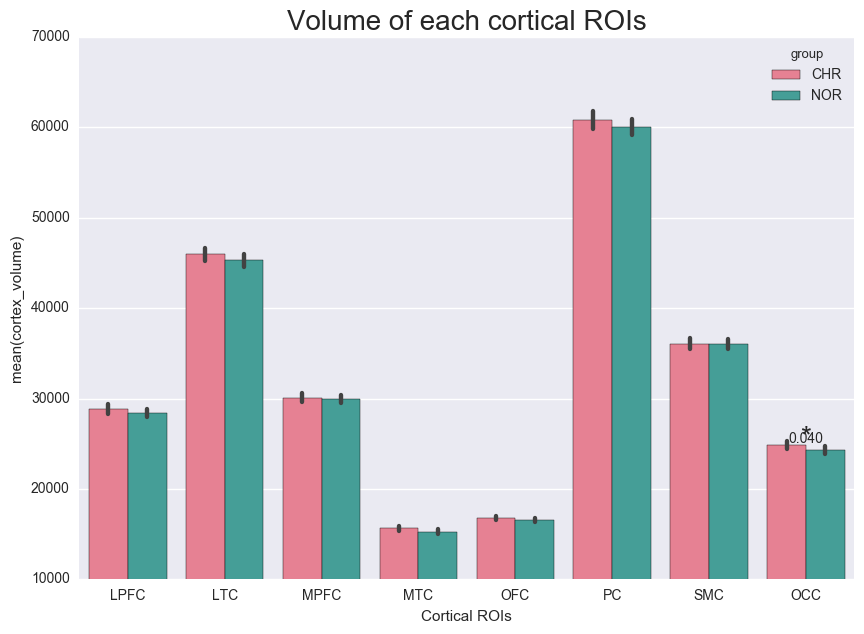

In [41]:
ax = plt.figure(figsize=(10,7))
ax = sns.barplot('cortex','cortex_volume', 
                 hue='group', 
                 palette=sns.color_palette("husl",2),
                 data=df_matched[['subject', 
                                  'cortex', 
                                  'cortex_volume',
                                  'group']].drop_duplicates())
ax.set_ylim(10000, 70000)
ax.set_title('Volume of each cortical ROIs', fontsize=20)
ax.set_xlabel('Cortical ROIs')


compare = 'cortex_volume'
for num, cortex in enumerate(df_matched.cortex.unique()):
    x = df_matched[['subject',
                    'cortex_volume', 
                    'group', 
                    'cortex', 
                    'age', 
                    'sex']].drop_duplicates().groupby('cortex').get_group(cortex)
    GROUP = x['group']
    VAR = x[compare]
    AGE = x['age']
    SEX = x['sex']

    formula = 'VAR ~ GROUP + AGE + SEX'
    lm = ols(formula, x).fit()
    output = anova_lm(lm)
    if output['PR(>F)'].GROUP < 0.05:

        print(output)
        gb = x.groupby('group')

        if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
            group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
            group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
        else:
            group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
            group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

        conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
        ax.annotate('*', xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=20)

        conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
        ax.annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=10)
#         print(conf_int_a)
#         ax.annotate("*", 
#                     xy=(num, conf_int_a[1]), 
#                     va='center', ha='center', fontsize=20)

plt.show()

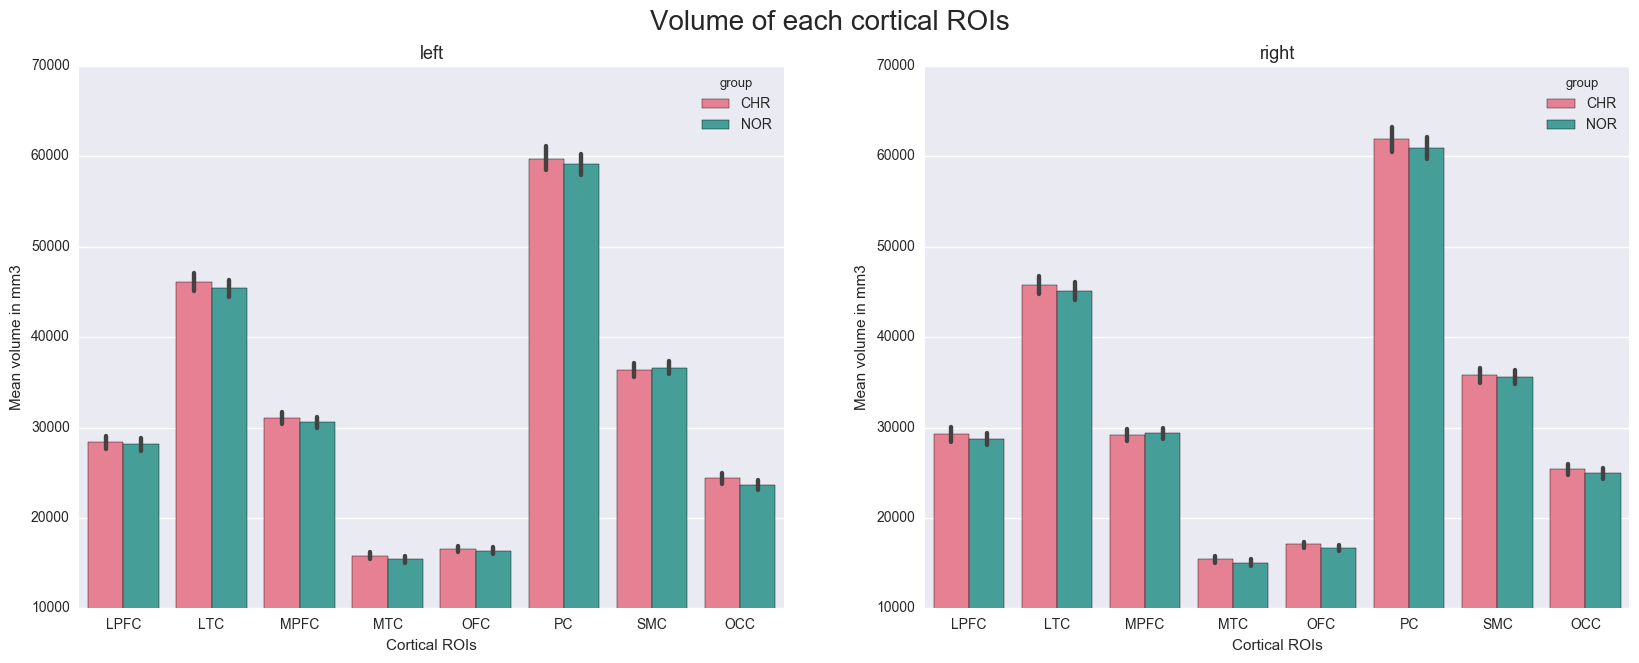

In [42]:
df_gb = df_matched.groupby('side')
fig, axes = plt.subplots(ncols=2, figsize=(20,7))
for side_num, side in enumerate(['left','right']):
    df = df_gb.get_group(side)[['cortex',
                                'cortex_volume',
                                'subject',
                                'group',
                                'age',
                                'sex']].drop_duplicates()
    
    sns.barplot('cortex',
                'cortex_volume',
                hue='group', 
                palette=sns.color_palette("husl",2),
                data=df, 
                ax=axes[side_num])
    
    axes[side_num].set_ylim(10000, 70000)
    axes[side_num].set_title(side, fontsize=13)
    axes[side_num].set_xlabel('Cortical ROIs')
    axes[side_num].set_ylabel('Mean volume in mm3')

    compare = 'cortex_volume'
    for num, cortex in enumerate(df_matched.cortex.unique()):
        x = df.groupby('cortex').get_group(cortex)
        GROUP = x['group']
        VAR = x[compare]
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        
        # If there is significant group effect
        if output['PR(>F)'].GROUP < 0.05:
            print(output)
            gb = x.groupby('group')
            groups = list(gb.groups.keys())

            # Determine the upper boundary of the plot
            # If the first group has higher mean than the second group
            if gb.get_group(groups[0])[compare].mean() > gb.get_group(groups[1])[compare].mean():
                group_mean_upper = gb.get_group(groups[0])[compare].mean()
                group_std_upper = gb.get_group(groups[0])[compare].std()
            # If the second group has higher mean than the second group
            else:
                group_mean_upper = gb.get_group(groups[1])[compare].mean()
                group_std_upper = gb.get_group(groups[1])[compare].std()
            
            # Estimate confidence interval
            # Edit here to make the significant sign higher up from the bar plot
            conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
            axes[side_num].annotate('*', 
                                    xy=(num, conf_int_a[1]), 
                                    va='center', 
                                    ha='center', 
                                    fontsize=20)
            conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
            axes[side_num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                    xy=(num, conf_int_a[1]), 
                                    va='center', 
                                    ha='center', 
                                    fontsize=10)
            
fig.suptitle('Volume of each cortical ROIs', fontsize=20)
plt.show()


In [43]:
df_matched.head()

,subject,side,cortex,threshold,cortex_volume,thalamus_volume,thalamus_seg_volume,thalamus_seg_mk,total_connectivity,relative_connectivity,group,folderName,sex,age,handedness
0,CHR04_PJH,left,LPFC,10,30171,10032,410,0.991797,4313.0,0.182248,CHR,CHR04_PJH,1,24,1
1,CHR04_PJH,left,LPFC,90,30171,10032,25,1.052972,682372.0,0.182248,CHR,CHR04_PJH,1,24,1
2,CHR04_PJH,left,LPFC,95,30171,10032,22,1.067865,603420.0,0.182248,CHR,CHR04_PJH,1,24,1
3,CHR04_PJH,left,LTC,10,47297,10032,263,0.782578,1611.0,0.033562,CHR,CHR04_PJH,1,24,1
4,CHR04_PJH,left,LTC,90,47297,10032,20,0.778343,166198.0,0.033562,CHR,CHR04_PJH,1,24,1


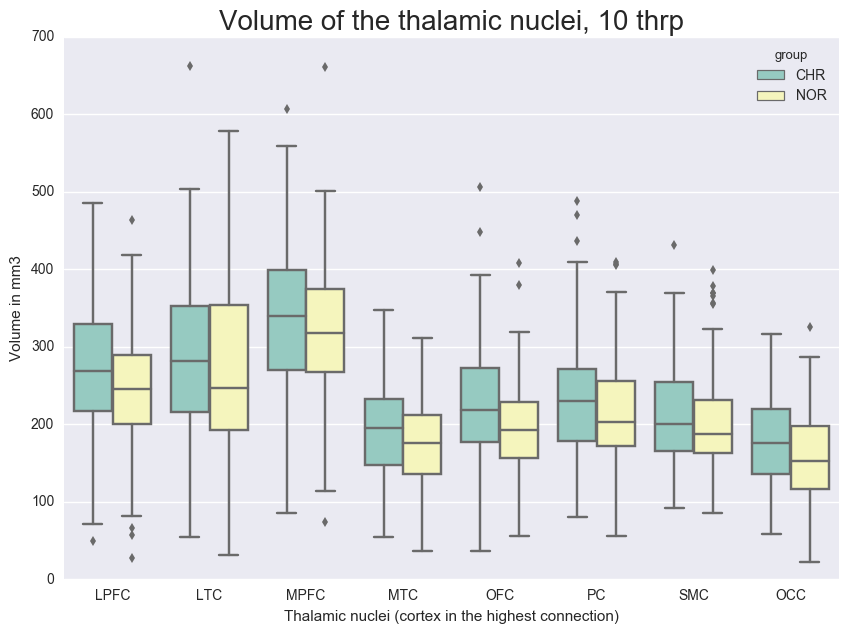

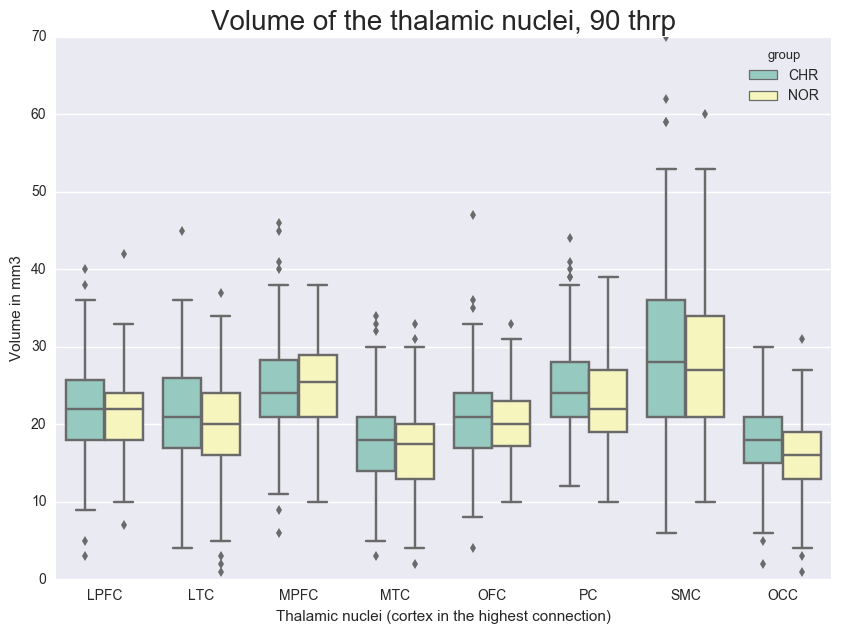

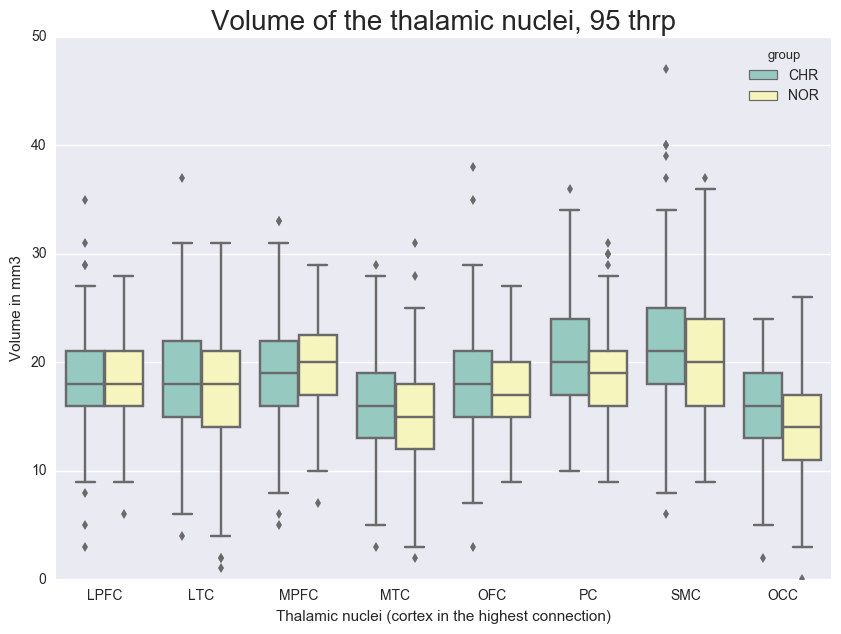

In [44]:
for thr in '10', '90', '95':
#     mk = 'Volume_'+thr
    ax = plt.figure(figsize=(10,7))
    ax = sns.boxplot('cortex', 'thalamus_seg_volume', 
                     hue='group', palette=sns.color_palette("Set3", 2),
                data=df_matched[['subject',
                                 'cortex',
                                 'thalamus_seg_volume',
                                 'group',
                                 'threshold']].drop_duplicates().groupby('threshold').get_group(thr))     

    ax.set_title('Volume of the thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_ylabel('Volume in mm3')
    ax.set_xlabel('Thalamic nuclei (cortex in the highest connection)')
    
    plt.show()

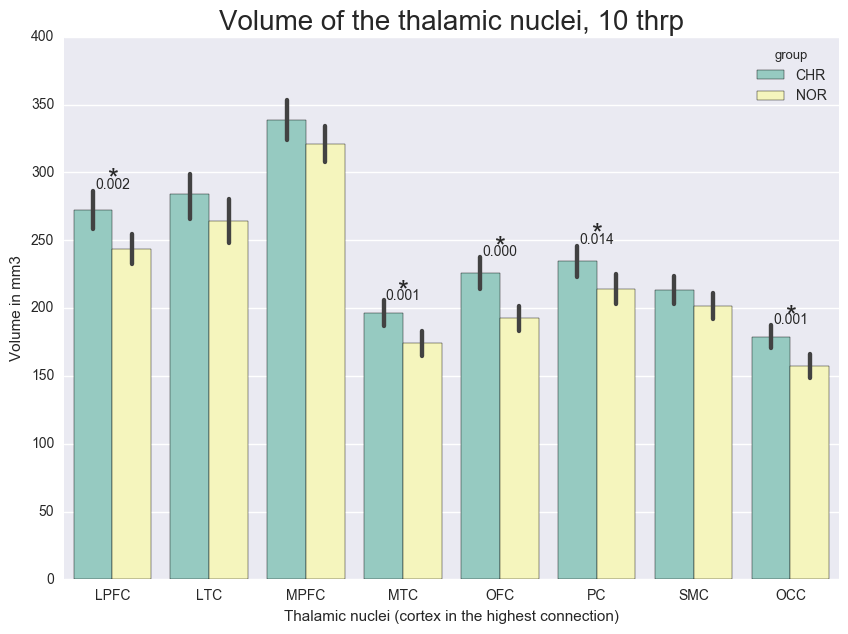

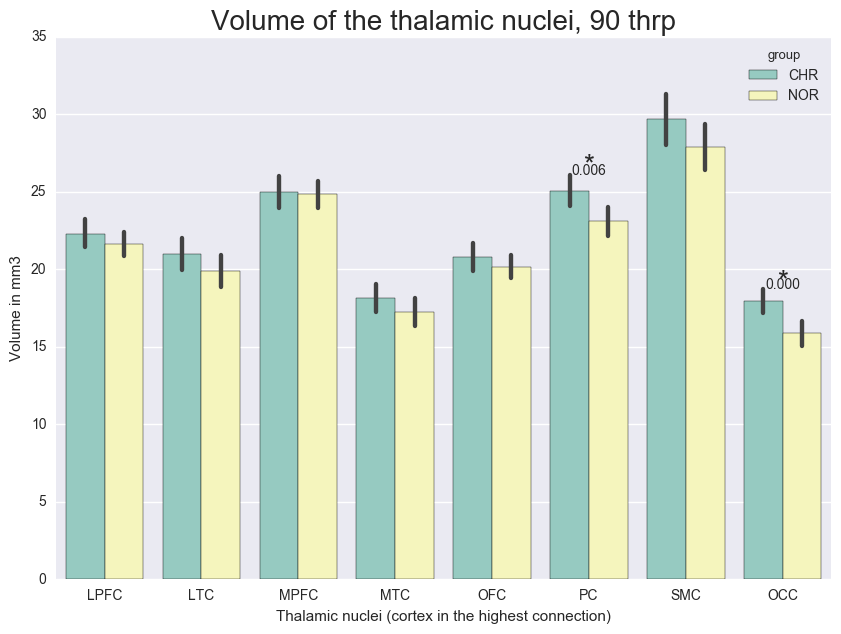

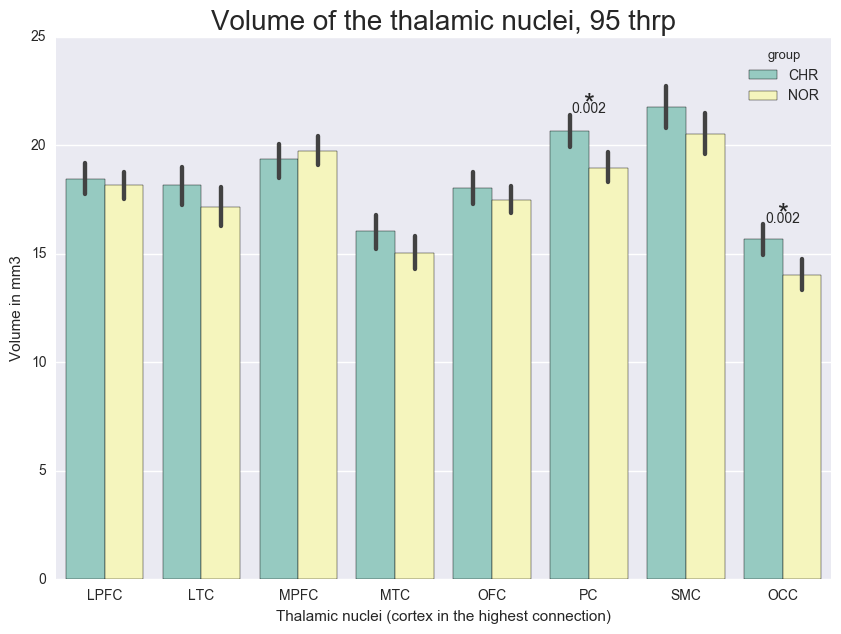

In [45]:
for thr in '10', '90', '95':
#     volume = 'Volume_'+thr
    ax = plt.figure(figsize=(10,7))
    ax = sns.barplot('cortex', 'thalamus_seg_volume', 
                     hue='group', palette=sns.color_palette("Set3", 2),
                data=df_matched[['subject',
                                 'cortex',
                                 'thalamus_seg_volume',
                                 'group',
                                 'threshold']].drop_duplicates().groupby('threshold').get_group(thr))     

    ax.set_title('Volume of the thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_ylabel('Volume in mm3')
    ax.set_xlabel('Thalamic nuclei (cortex in the highest connection)')
    
    
    compare = 'thalamus_seg_volume'
    for num, cortex in enumerate(df_matched.cortex.unique()):
        x = df_matched[['subject',
                        'cortex',
                        'thalamus_seg_volume',
                        'age',
                        'sex',
                        'group',
                        'threshold']].drop_duplicates().groupby(['cortex','threshold']).get_group((cortex, thr))
        GROUP = x['group']
        VAR = x[compare]
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        if output['PR(>F)'].GROUP < 0.05:

    #         print(output)
            gb = x.groupby('group')

            if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
            else:
                group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

            conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
            ax.annotate('*', xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=20)

            conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
            ax.annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    #         print(conf_int_a)
    #         ax.annotate("*", 
    #                     xy=(num, conf_int_a[1]), 
    #                     va='center', ha='center', fontsize=20)

    plt.show()

In [46]:
df_matched.head()

,subject,side,cortex,threshold,cortex_volume,thalamus_volume,thalamus_seg_volume,thalamus_seg_mk,total_connectivity,relative_connectivity,group,folderName,sex,age,handedness
0,CHR04_PJH,left,LPFC,10,30171,10032,410,0.991797,4313.0,0.182248,CHR,CHR04_PJH,1,24,1
1,CHR04_PJH,left,LPFC,90,30171,10032,25,1.052972,682372.0,0.182248,CHR,CHR04_PJH,1,24,1
2,CHR04_PJH,left,LPFC,95,30171,10032,22,1.067865,603420.0,0.182248,CHR,CHR04_PJH,1,24,1
3,CHR04_PJH,left,LTC,10,47297,10032,263,0.782578,1611.0,0.033562,CHR,CHR04_PJH,1,24,1
4,CHR04_PJH,left,LTC,90,47297,10032,20,0.778343,166198.0,0.033562,CHR,CHR04_PJH,1,24,1


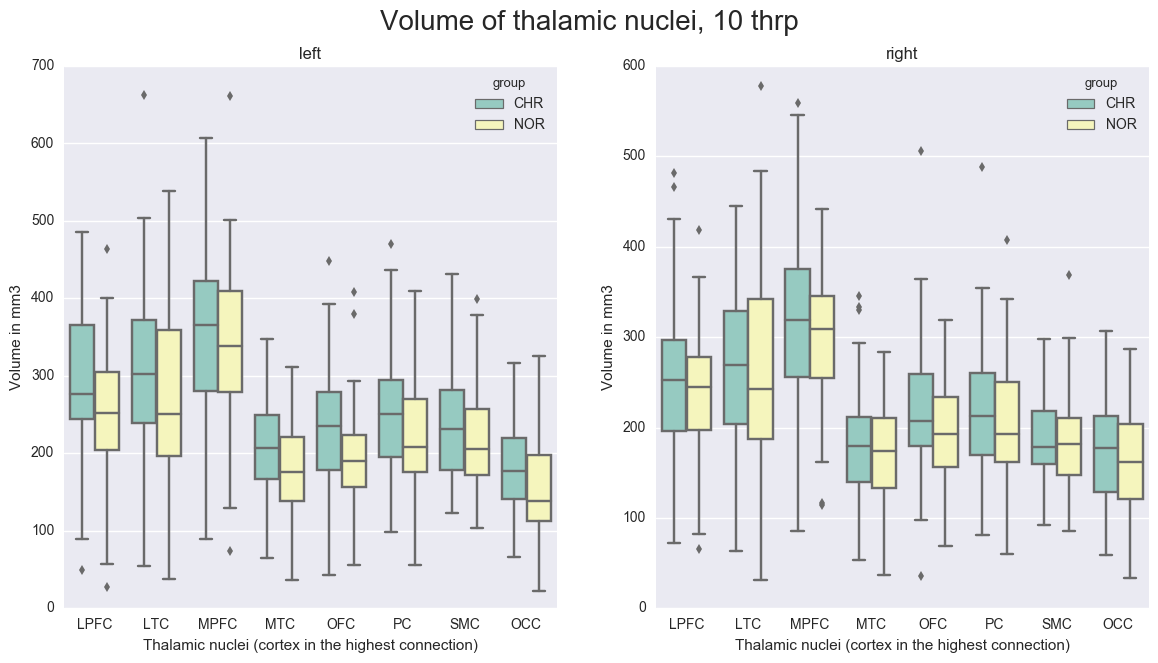

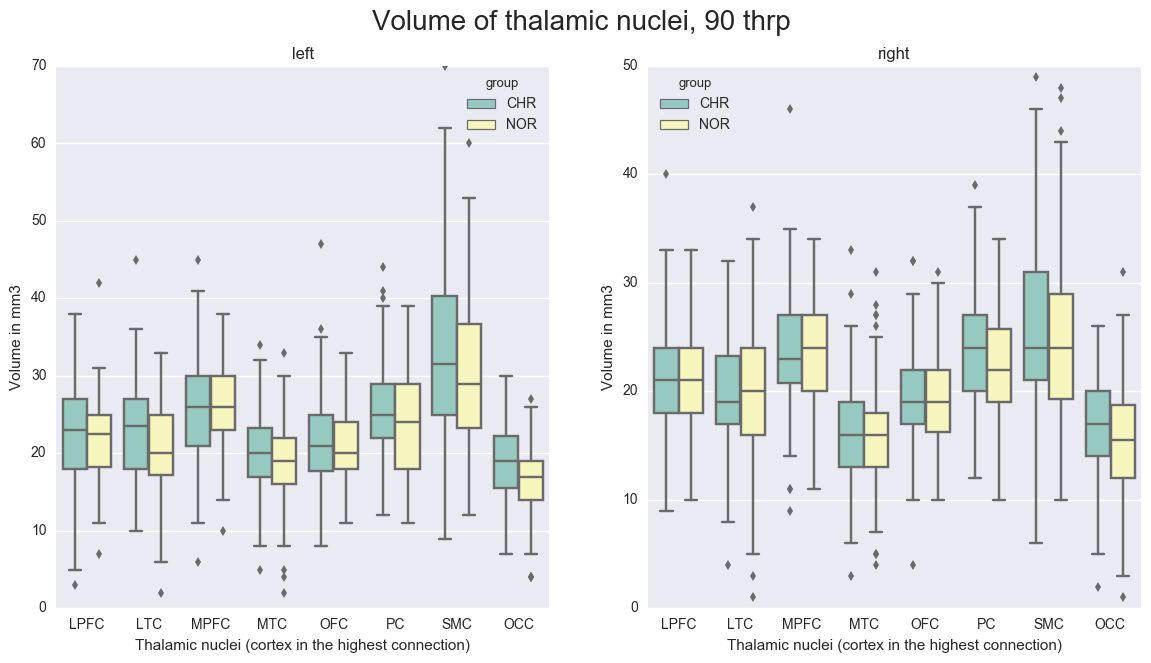

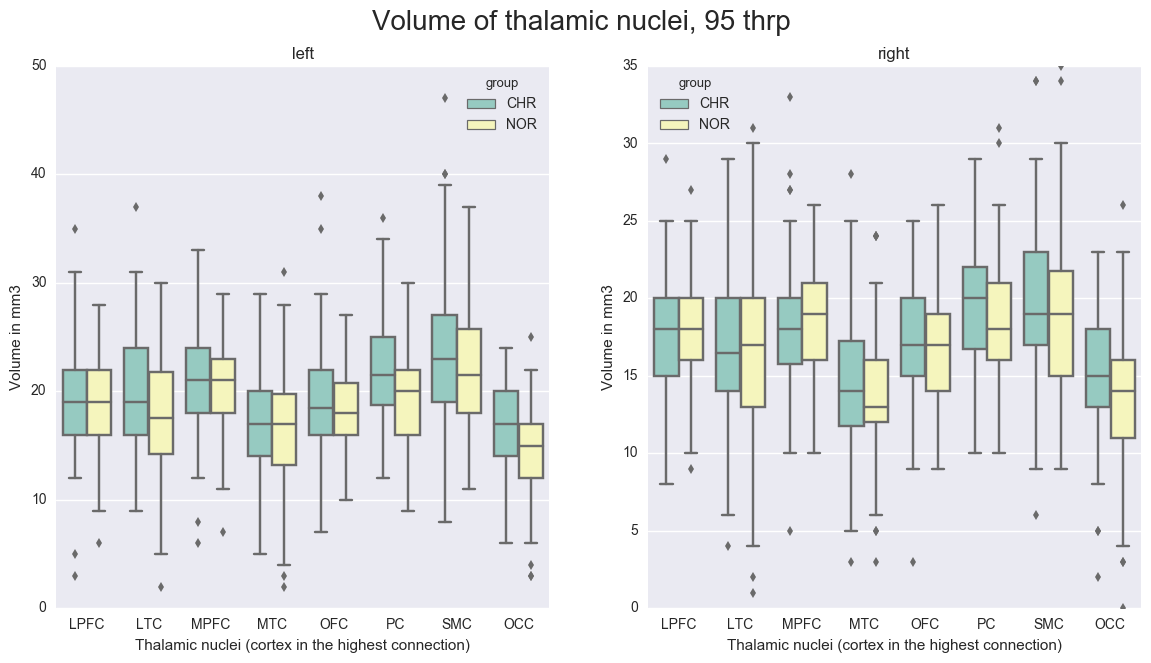

In [47]:
for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.boxplot('cortex', 
                    'thalamus_seg_volume',
                    hue='group', 
                    palette=sns.color_palette("Set3", 2),
                    data=df_matched[['subject','side','cortex','threshold','group',
                                     'thalamus_seg_volume']].drop_duplicates().groupby(['side','threshold']).get_group((side, thr)),
                    ax=axes[num])
        axes[num].set_ylabel('Volume in mm3')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)


    fig.suptitle('Volume of thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    plt.show()

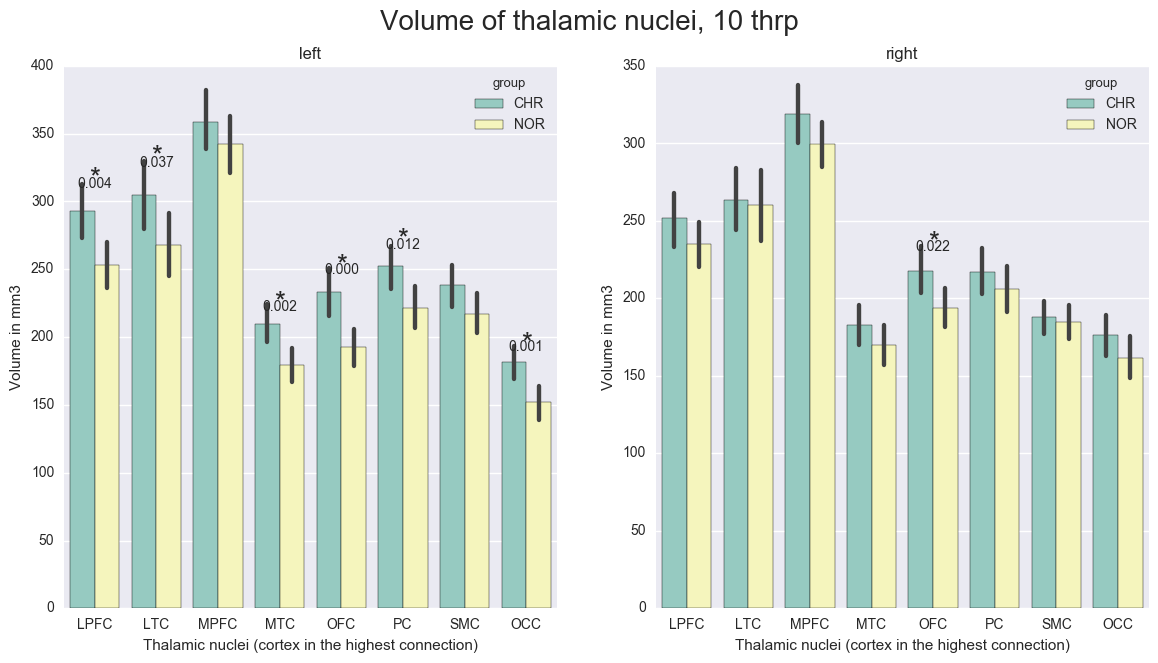

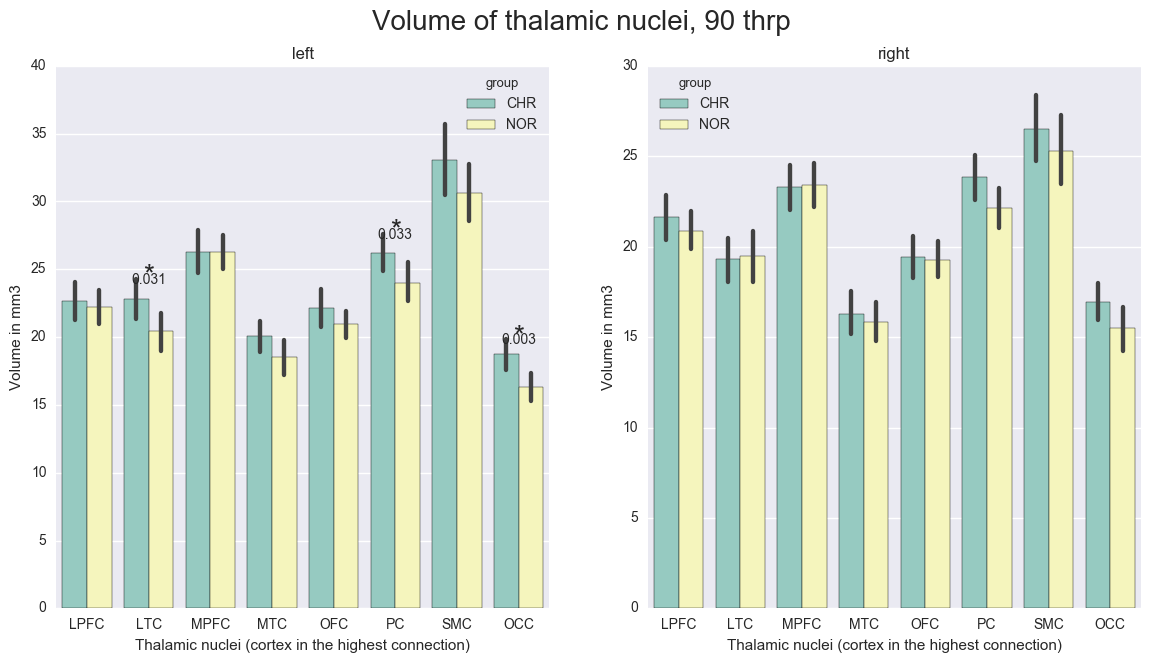

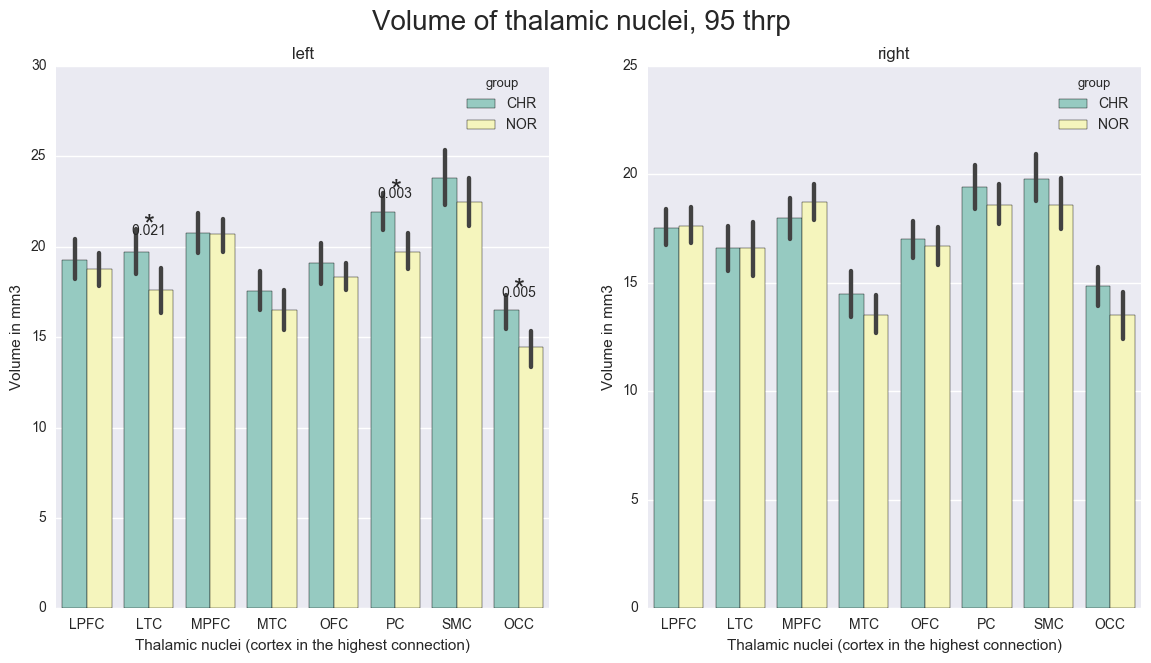

In [48]:
for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    'thalamus_seg_volume',
                    hue='group', 
                    palette=sns.color_palette("Set3", 2),
                    data=df_matched[['subject','side','cortex','threshold','group',
                                     'thalamus_seg_volume']].drop_duplicates().groupby(['side','threshold']).get_group((side, thr)),
                    ax=axes[num])
        axes[num].set_ylabel('Volume in mm3')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
        

        compare = 'thalamus_seg_volume'
        for roi_num, cortex in enumerate(df_matched.cortex.unique()):
            x = df_matched[['subject','side','cortex','threshold','group','age','sex',
                                     'thalamus_seg_volume']].drop_duplicates().groupby(['side','threshold','cortex']).get_group((side, thr, cortex))
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
        #         print(output)
                gb = x.groupby('group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)

    fig.suptitle('Volume of thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    plt.show()

In [49]:
df_matched.head()

,subject,side,cortex,threshold,cortex_volume,thalamus_volume,thalamus_seg_volume,thalamus_seg_mk,total_connectivity,relative_connectivity,group,folderName,sex,age,handedness
0,CHR04_PJH,left,LPFC,10,30171,10032,410,0.991797,4313.0,0.182248,CHR,CHR04_PJH,1,24,1
1,CHR04_PJH,left,LPFC,90,30171,10032,25,1.052972,682372.0,0.182248,CHR,CHR04_PJH,1,24,1
2,CHR04_PJH,left,LPFC,95,30171,10032,22,1.067865,603420.0,0.182248,CHR,CHR04_PJH,1,24,1
3,CHR04_PJH,left,LTC,10,47297,10032,263,0.782578,1611.0,0.033562,CHR,CHR04_PJH,1,24,1
4,CHR04_PJH,left,LTC,90,47297,10032,20,0.778343,166198.0,0.033562,CHR,CHR04_PJH,1,24,1


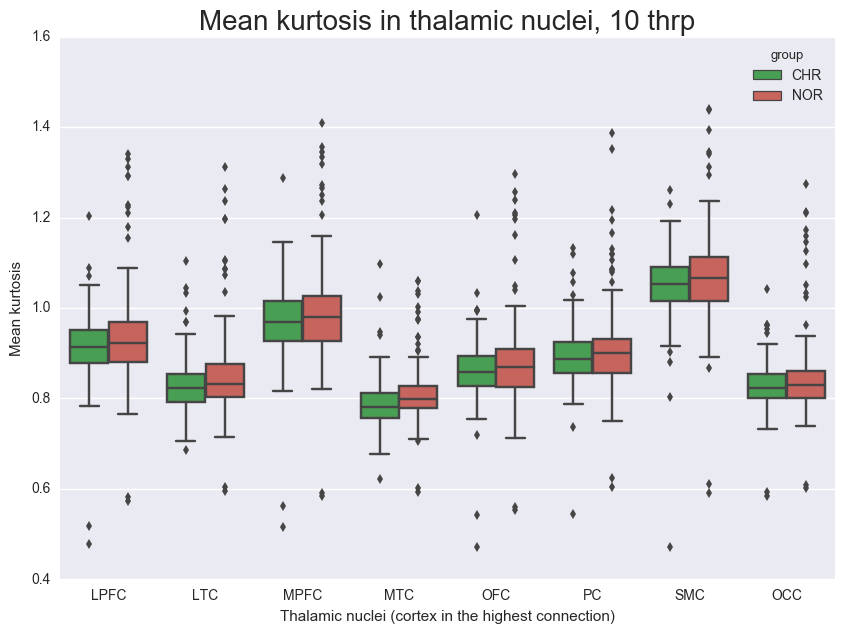

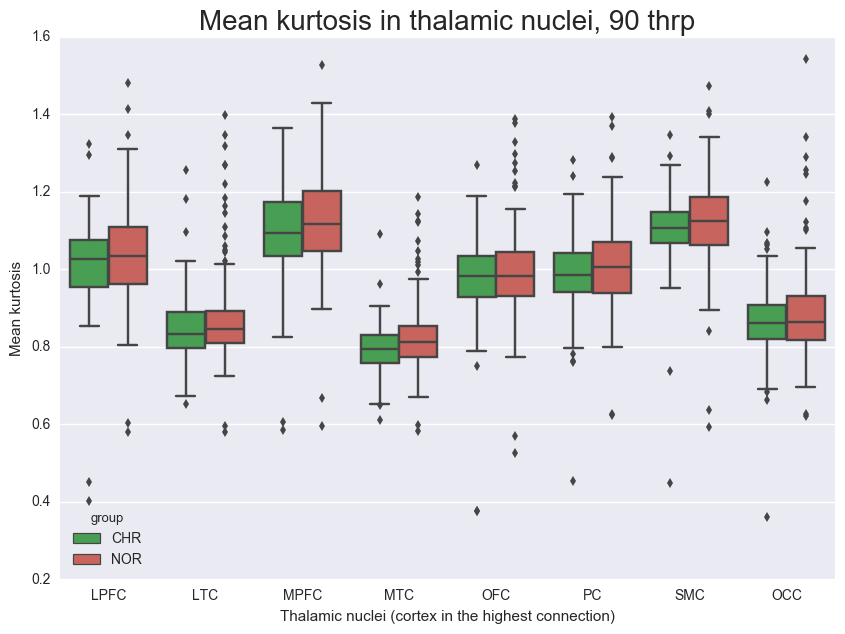

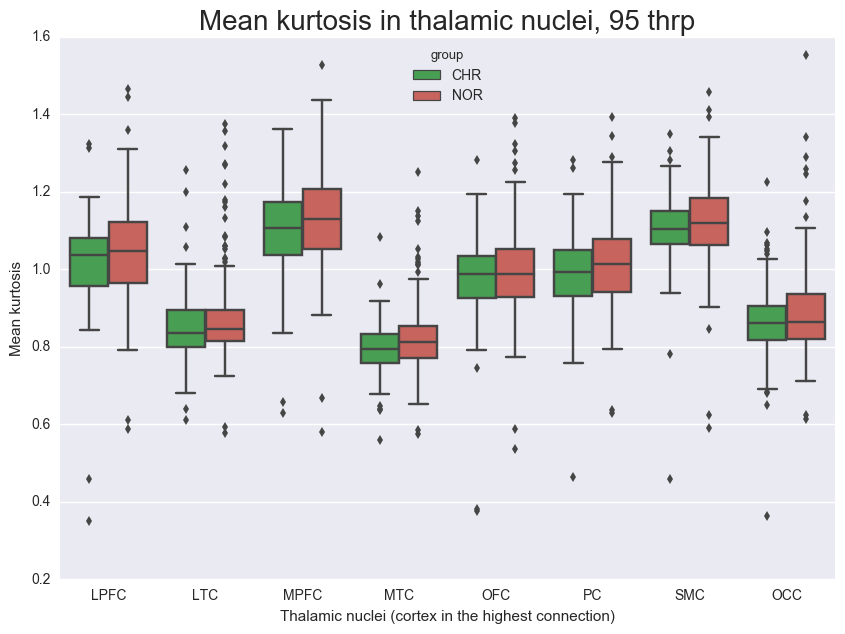

In [50]:
df_gb = df_matched.groupby('threshold')
for thr in '10', '90', '95':
    ax = plt.figure(figsize=(10,7))
    ax = sns.boxplot('cortex',
                     'thalamus_seg_mk',
                     hue='group', 
                     palette=sns.xkcd_palette(['medium green','pale red']),
                     data = df_gb.get_group(thr))     

    ax.set_title('Mean kurtosis in thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_ylabel('Mean kurtosis')
    ax.set_xlabel('Thalamic nuclei (cortex in the highest connection)')
    plt.show()

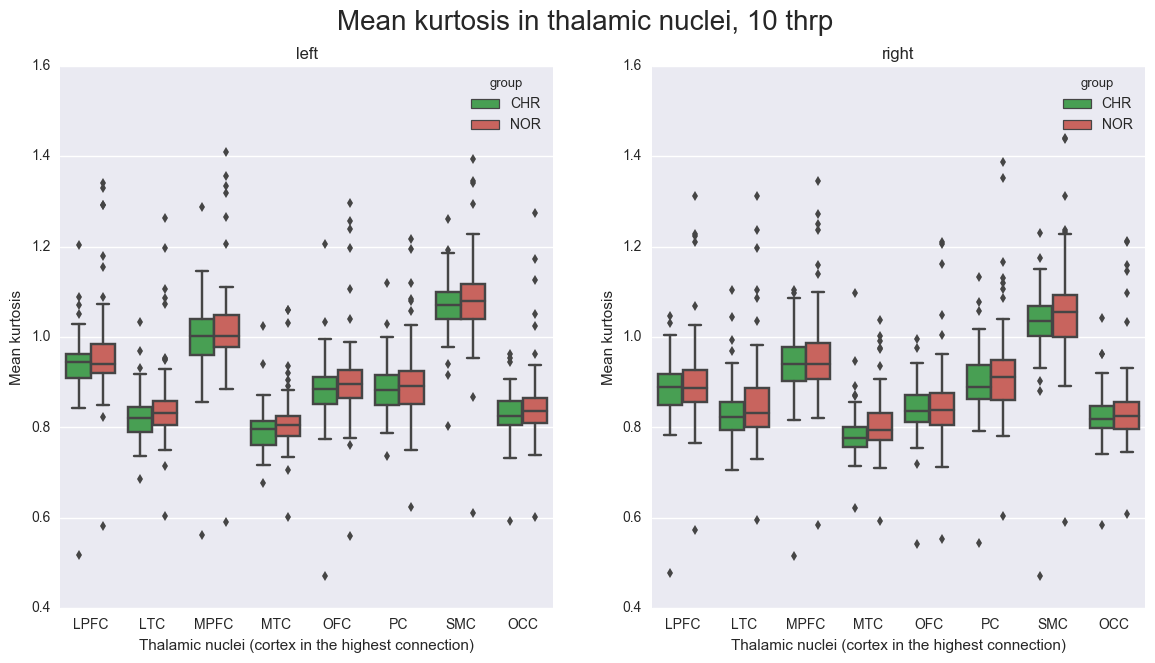

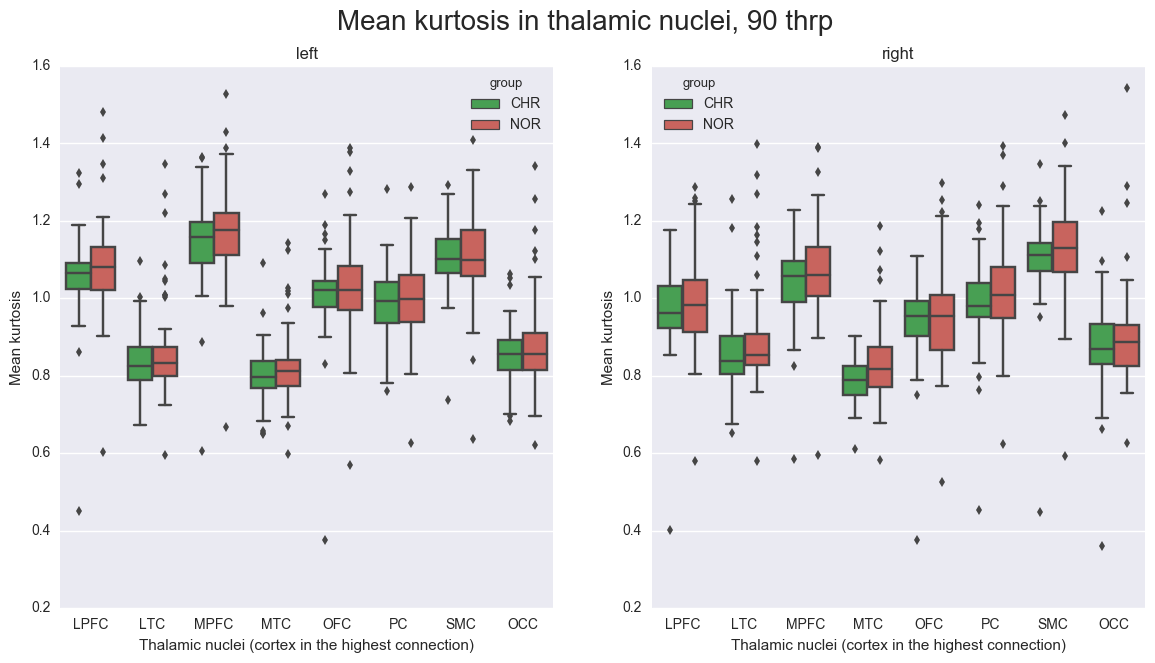

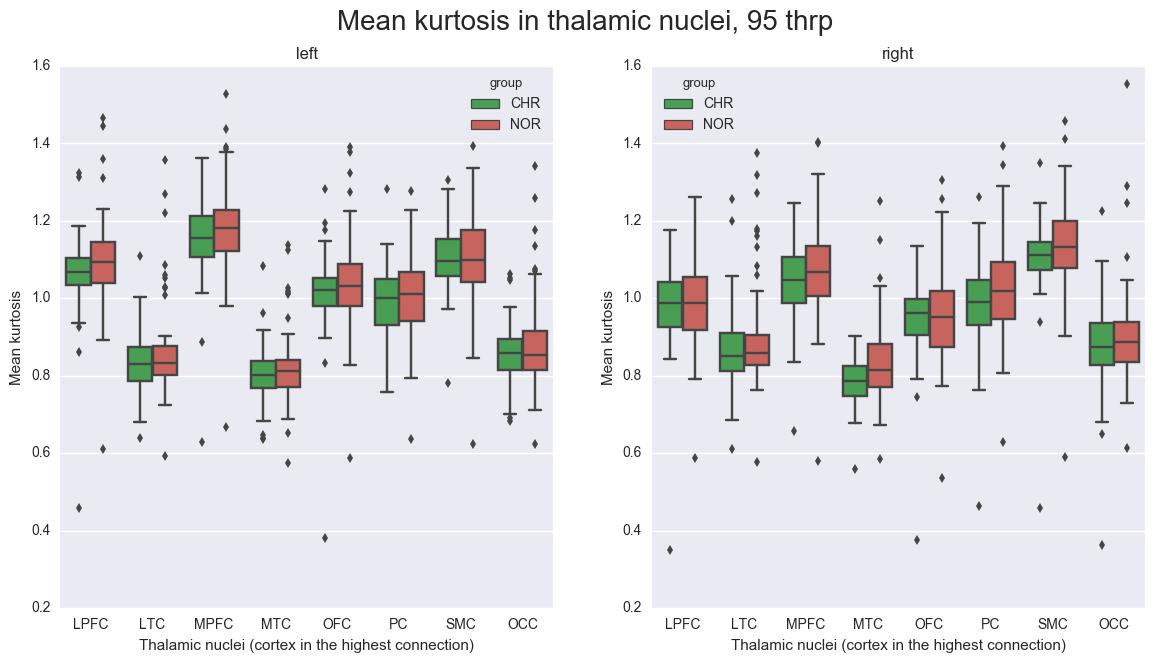

In [51]:
df_gb = df_matched.groupby(['threshold', 'side'])

for thr in '10', '90', '95':
    mk = 'mk_'+thr
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.boxplot('cortex', 
                    'thalamus_seg_mk',
                    hue='group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Mean kurtosis')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
        

    fig.suptitle('Mean kurtosis in thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    plt.show()

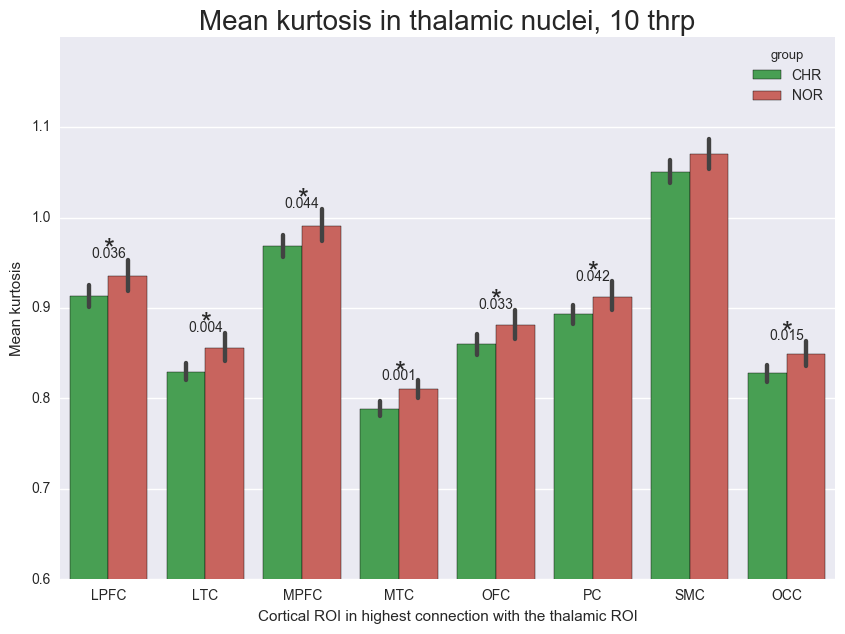

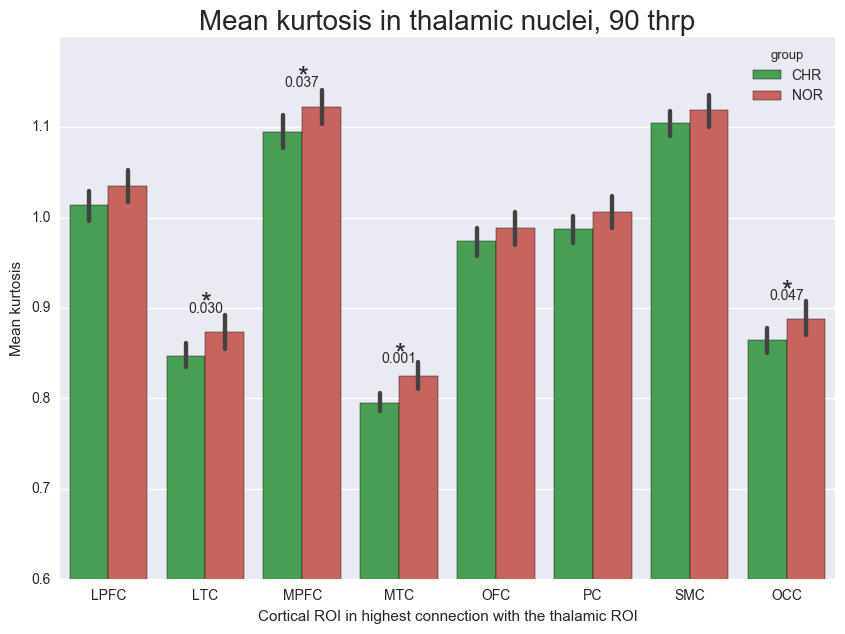

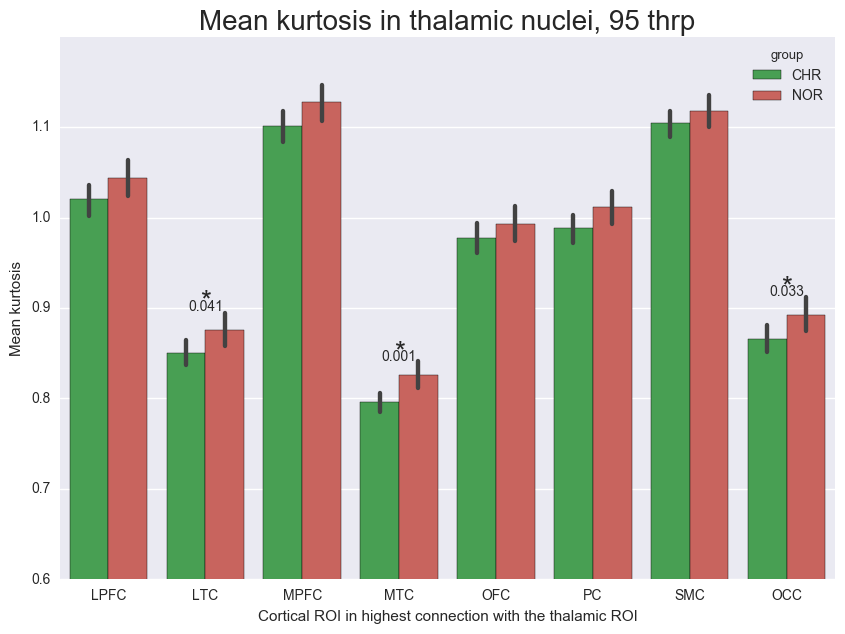

In [52]:
df_gb = df_matched.groupby('threshold')

for thr in '10', '90', '95':
    mk = 'mk_'+thr
    ax = plt.figure(figsize=(10,7))
    ax = sns.barplot('cortex', 
                     'thalamus_seg_mk', 
                     hue='group', 
                     palette=sns.xkcd_palette(['medium green','pale red']),
                     data=df_gb.get_group(thr))     
    ax.set_ylim(0.6, 1.2)
    ax.set_title('Mean kurtosis in thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_ylabel('Mean kurtosis')
    ax.set_xlabel('Cortical ROI in highest connection with the thalamic ROI')
    
    compare = 'thalamus_seg_mk'
    for num, cortex in enumerate(df_matched.cortex.unique()):
        x = df_gb.get_group(thr).groupby('cortex').get_group(cortex)
        GROUP = x['group']
        VAR = x[compare]
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        if output['PR(>F)'].GROUP < 0.05:

    #         print(output)
            gb = x.groupby('group')

            if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
            else:
                group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

            conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
            ax.annotate('*', xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=20)

            conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
            ax.annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    #         print(conf_int_a)
    #         ax.annotate("*", 
    #                     xy=(num, conf_int_a[1]), 
    #                     va='center', ha='center', fontsize=20)

    plt.show()

             df    sum_sq   mean_sq         F    PR(>F)
GROUP       1.0  0.023865  0.023865  4.234151  0.041350
AGE         1.0  0.033770  0.033770  5.991662  0.015528
SEX         1.0  0.011257  0.011257  1.997217  0.159660
Residual  150.0  0.845432  0.005636       NaN       NaN
             df    sum_sq   mean_sq         F    PR(>F)
GROUP       1.0  0.017342  0.017342  5.088983  0.025524
AGE         1.0  0.013335  0.013335  3.913129  0.049742
SEX         1.0  0.001487  0.001487  0.436350  0.509902
Residual  150.0  0.511173  0.003408       NaN       NaN
             df    sum_sq   mean_sq         F    PR(>F)
GROUP       1.0  0.030513  0.030513  3.996371  0.047405
AGE         1.0  0.038334  0.038334  5.020701  0.026515
SEX         1.0  0.047602  0.047602  6.234448  0.013609
Residual  150.0  1.145289  0.007635       NaN       NaN
             df    sum_sq   mean_sq         F    PR(>F)
GROUP       1.0  0.020351  0.020351  5.201074  0.023982
AGE         1.0  0.006197  0.006197  1.583765  0

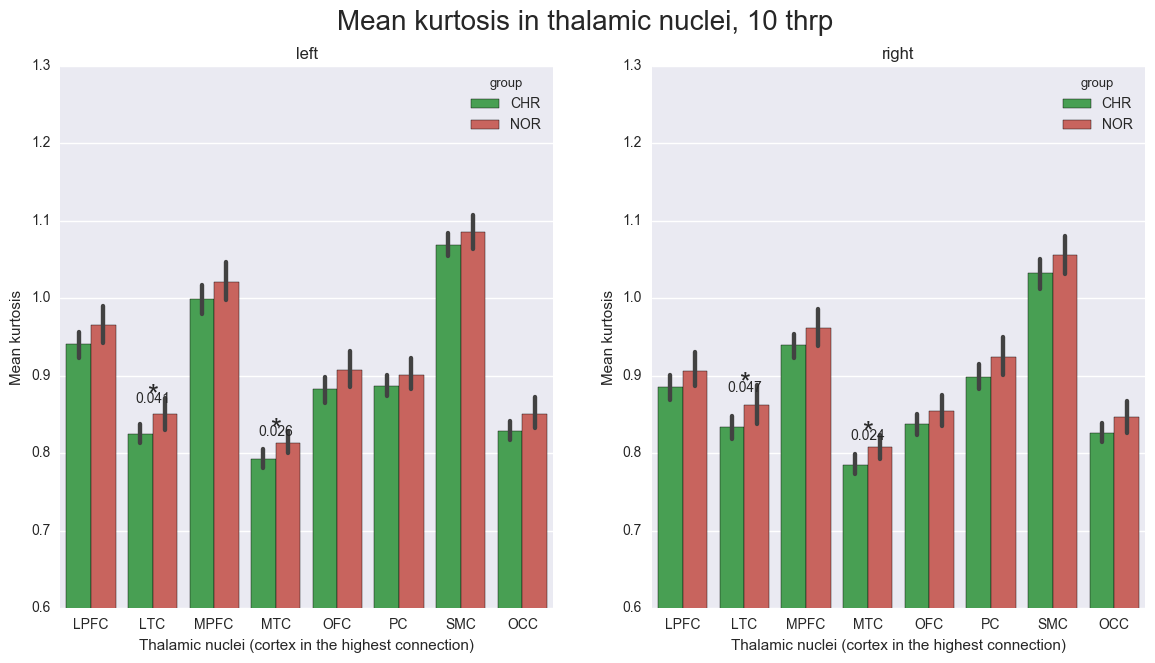

             df    sum_sq   mean_sq         F    PR(>F)
GROUP       1.0  0.056814  0.056814  8.809385  0.003489
AGE         1.0  0.007330  0.007330  1.136576  0.288090
SEX         1.0  0.002318  0.002318  0.359496  0.549691
Residual  150.0  0.967382  0.006449       NaN       NaN


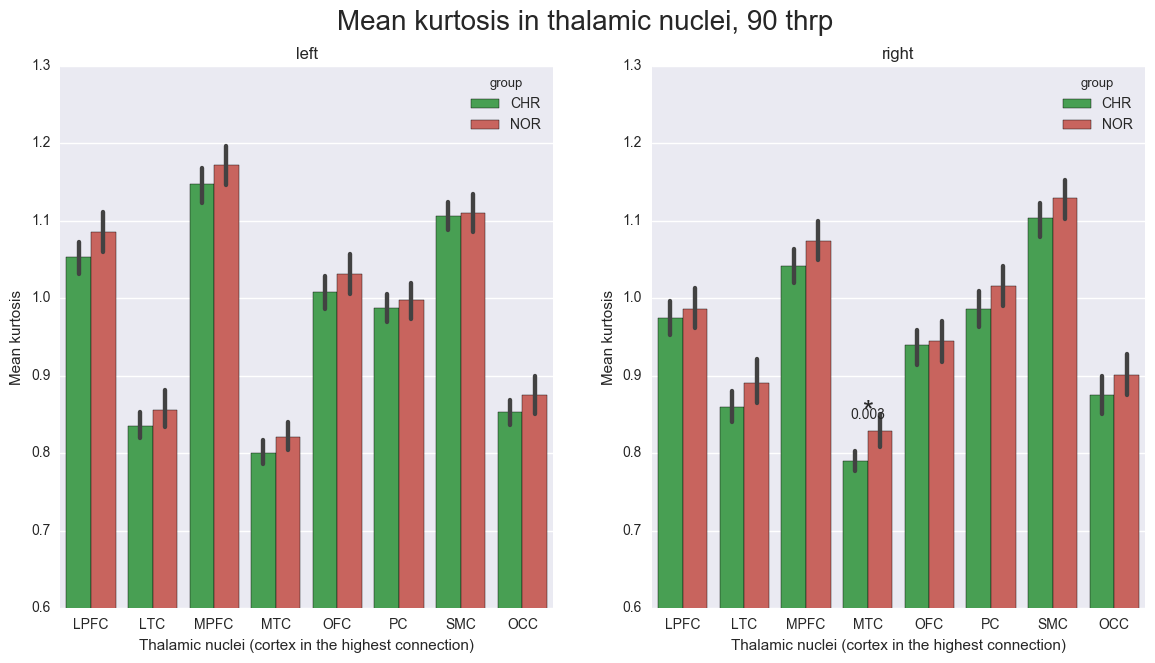

             df    sum_sq   mean_sq         F    PR(>F)
GROUP       1.0  0.044348  0.044348  3.950817  0.048669
AGE         1.0  0.043148  0.043148  3.843973  0.051778
SEX         1.0  0.047405  0.047405  4.223196  0.041610
Residual  150.0  1.683741  0.011225       NaN       NaN
             df    sum_sq   mean_sq          F    PR(>F)
GROUP       1.0  0.069120  0.069120  10.106863  0.001795
AGE         1.0  0.009015  0.009015   1.318156  0.252751
SEX         1.0  0.003182  0.003182   0.465347  0.496188
Residual  150.0  1.025841  0.006839        NaN       NaN


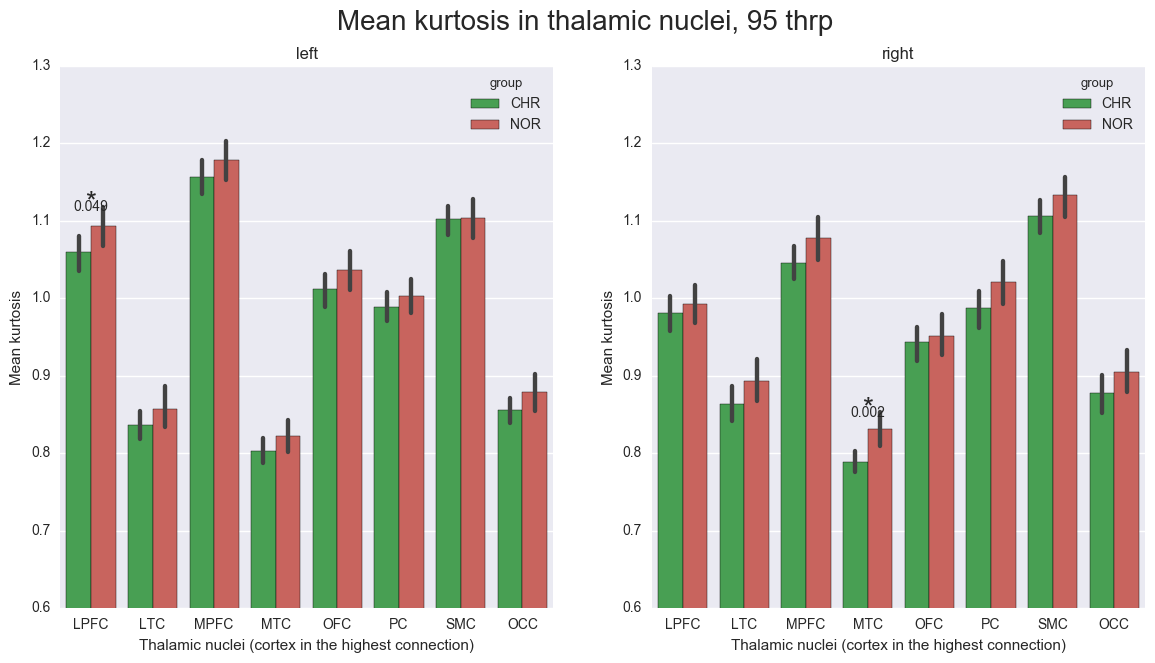

In [53]:
df_gb = df_matched.groupby(['threshold', 'side'])

for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    'thalamus_seg_mk',
                    hue='group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Mean kurtosis')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
        axes[num].set_ylim(0.6, 1.3)

        compare = 'thalamus_seg_mk'
        for roi_num, cortex in enumerate(df_matched.cortex.unique()):
            x = df_gb.get_group((thr,side)).groupby('cortex').get_group(cortex)
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
                print(output)
                gb = x.groupby('group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    fig.suptitle('Mean kurtosis in thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    plt.show()

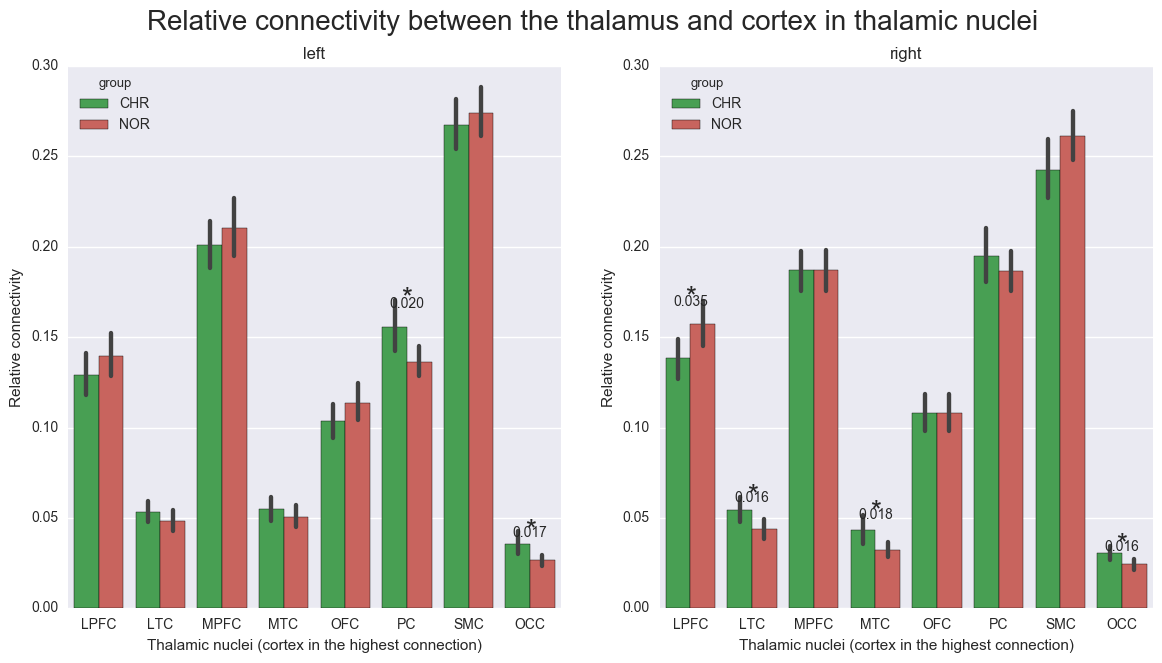

In [84]:
df_gb = df_matched.groupby(['threshold', 'side'])
# Arbitrary value
thr = '10'


fig, axes = plt.subplots(ncols=2, figsize=(14,7))
for num, side in enumerate(['left', 'right']):
    sns.barplot('cortex', 
                'relative_connectivity',
                hue='group', 
                palette=sns.xkcd_palette(['medium green','pale red']),
                data=df_gb.get_group((thr, side)),
                ax=axes[num])
    axes[num].set_ylabel('Relative connectivity')
    axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
    axes[num].set_title(side)
#         axes[num].set_ylim(0.6, 1.3)

    compare = 'relative_connectivity'
    for roi_num, cortex in enumerate(df_matched.cortex.unique()):
        x = df_gb.get_group((thr,side)).groupby('cortex').get_group(cortex)
        GROUP = x['group']
        VAR = x[compare]
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        if output['PR(>F)'].GROUP < 0.05:
#                 print(output)
            gb = x.groupby('group')

            if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
            else:
                group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

            conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
            axes[num].annotate('*', 
                               xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

            conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
            axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                               xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)
fig.suptitle('Relative connectivity between the thalamus and cortex in thalamic nuclei'.format(thr), fontsize=20)
plt.show()

               df        sum_sq       mean_sq          F    PR(>F)
GROUP         1.0  1.050906e+12  1.050906e+12   7.078345  0.008663
AGE           1.0  8.369556e+11  8.369556e+11   5.637288  0.018865
SEX           1.0  1.077675e+11  1.077675e+11   0.725865  0.395603
THAL_VOL      1.0  3.729833e+12  3.729833e+12  25.122175  0.000002
CORTEX_VOL    1.0  3.109645e+11  3.109645e+11   2.094491  0.149946
Residual    148.0  2.197323e+13  1.484678e+11        NaN       NaN
               df        sum_sq       mean_sq          F    PR(>F)
GROUP         1.0  5.045489e+12  5.045489e+12   4.860187  0.029027
AGE           1.0  8.690839e+11  8.690839e+11   0.837166  0.361697
SEX           1.0  2.701153e+11  2.701153e+11   0.260195  0.610746
THAL_VOL      1.0  2.177780e+13  2.177780e+13  20.977986  0.000010
CORTEX_VOL    1.0  3.777773e+11  3.777773e+11   0.363903  0.547270
Residual    148.0  1.536427e+14  1.038126e+12        NaN       NaN
               df        sum_sq       mean_sq         F    PR(

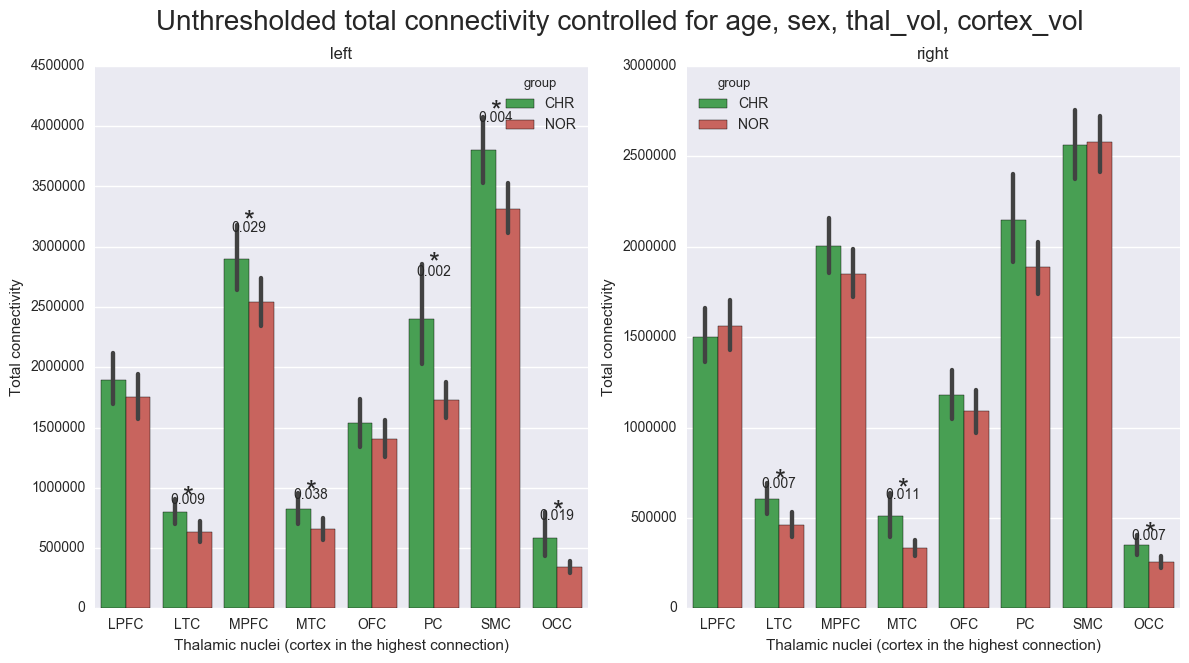

In [108]:
df_gb = df_matched.groupby(['threshold', 'side'])
# Arbitrary value
thr = '10'


fig, axes = plt.subplots(ncols=2, figsize=(14,7))
for num, side in enumerate(['left', 'right']):
    sns.barplot('cortex', 
                'total_connectivity_raw',
                hue='group', 
                palette=sns.xkcd_palette(['medium green','pale red']),
                data=df_gb.get_group((thr, side)),
                ax=axes[num])
    axes[num].set_ylabel('Total connectivity')
    axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
    axes[num].set_title(side)
#         axes[num].set_ylim(0.6, 1.3)

    compare = 'total_connectivity_raw'
    for roi_num, cortex in enumerate(df_matched.cortex.unique()):
        x = df_gb.get_group((thr,side)).groupby('cortex').get_group(cortex)
        GROUP = x['group']
        VAR = x[compare]
        THAL_VOL = x['thalamus_volume']
        CORTEX_VOL = x['cortex_volume']
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX + THAL_VOL + CORTEX_VOL'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        if output['PR(>F)'].GROUP < 0.05:
            print(output)
            gb = x.groupby('group')

            if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
            else:
                group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

            conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
            axes[num].annotate('*', 
                               xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

            conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
            axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                               xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)
fig.suptitle('Unthresholded total connectivity controlled for age, sex, thal_vol, cortex_vol', fontsize=20)
plt.show()

               df    sum_sq   mean_sq         F    PR(>F)
GROUP         1.0  0.013830  0.013830  5.699559  0.018232
AGE           1.0  0.001547  0.001547  0.637458  0.425912
SEX           1.0  0.000349  0.000349  0.143934  0.704945
THAL_VOL      1.0  0.016702  0.016702  6.883081  0.009613
CORTEX_VOL    1.0  0.000010  0.000010  0.004302  0.947794
Residual    148.0  0.359132  0.002427       NaN       NaN
               df    sum_sq   mean_sq         F    PR(>F)
GROUP         1.0  0.003031  0.003031  5.808021  0.017181
AGE           1.0  0.000291  0.000291  0.558254  0.456150
SEX           1.0  0.001184  0.001184  2.268961  0.134120
THAL_VOL      1.0  0.000042  0.000042  0.080096  0.777563
CORTEX_VOL    1.0  0.000443  0.000443  0.847944  0.358633
Residual    148.0  0.077237  0.000522       NaN       NaN
               df    sum_sq   mean_sq         F    PR(>F)
GROUP         1.0  0.013362  0.013362  4.506738  0.035426
AGE           1.0  0.000006  0.000006  0.002082  0.963668
SEX           

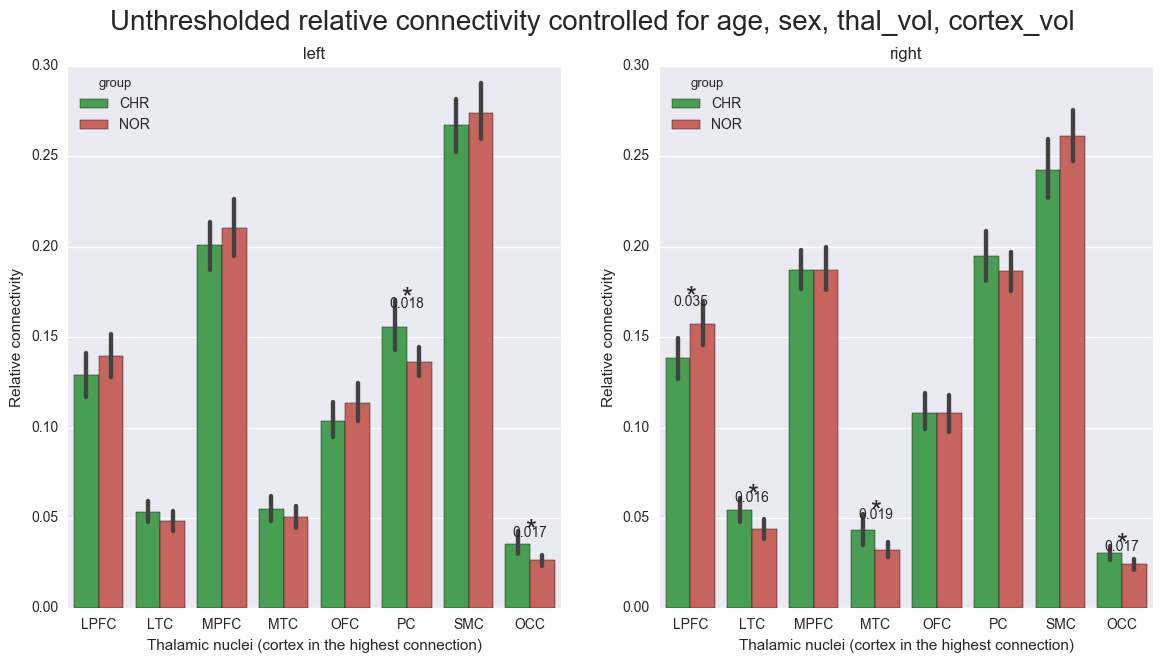

In [111]:
df_gb = df_matched.groupby(['threshold', 'side'])
# Arbitrary value
thr = '10'


fig, axes = plt.subplots(ncols=2, figsize=(14,7))
for num, side in enumerate(['left', 'right']):
    sns.barplot('cortex', 
                'relative_connectivity',
                hue='group', 
                palette=sns.xkcd_palette(['medium green','pale red']),
                data=df_gb.get_group((thr, side)),
                ax=axes[num])
    axes[num].set_ylabel('Relative connectivity')
    axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
    axes[num].set_title(side)
#         axes[num].set_ylim(0.6, 1.3)

    compare = 'relative_connectivity'
    for roi_num, cortex in enumerate(df_matched.cortex.unique()):
        x = df_gb.get_group((thr,side)).groupby('cortex').get_group(cortex)
        GROUP = x['group']
        VAR = x[compare]
        THAL_VOL = x['thalamus_volume']
        CORTEX_VOL = x['cortex_volume']
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX + THAL_VOL + CORTEX_VOL'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        if output['PR(>F)'].GROUP < 0.05:
            print(output)
            gb = x.groupby('group')

            if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
            else:
                group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

            conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
            axes[num].annotate('*', 
                               xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

            conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
            axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                               xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)
fig.suptitle('Unthresholded relative connectivity controlled for age, sex, thal_vol, cortex_vol', fontsize=20)
plt.show()

/home/kangik/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


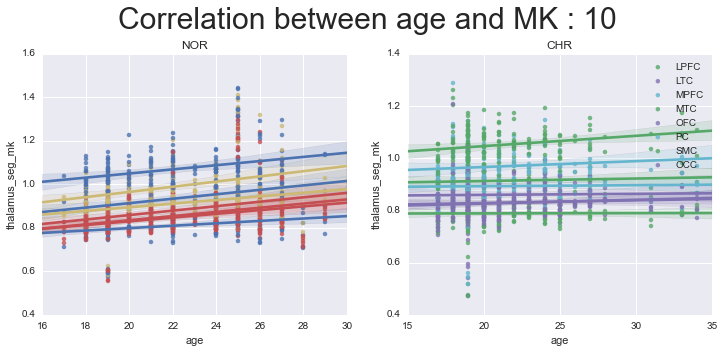

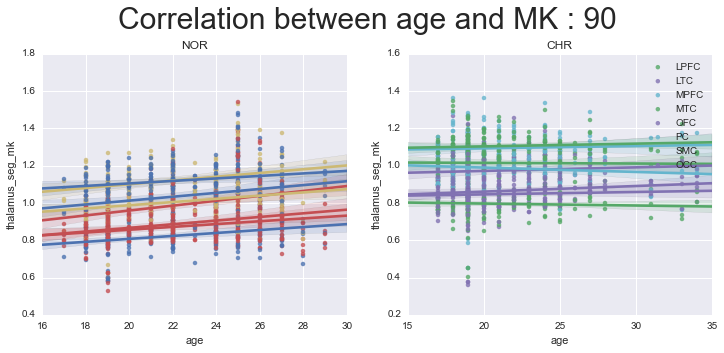

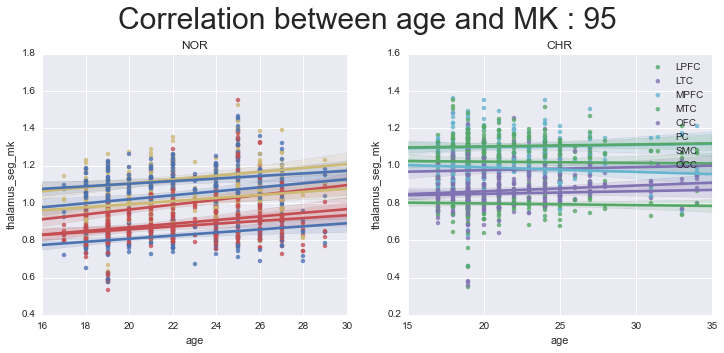

In [118]:
df_gb = df_matched.groupby(['group','cortex','threshold'])
for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(12,5))
    for cortex in df_matched.cortex.unique():
        sns.regplot('age', 
                    'thalamus_seg_mk',
                    df_gb.get_group(('NOR', cortex, thr)),
                    label = cortex,
                    ax=axes[0])
        sns.regplot('age', 
                    'thalamus_seg_mk',
                    df_gb.get_group(('CHR', cortex, thr)),
                    label = cortex,
                    ax=axes[1])
    plt.subplots_adjust(top=0.85)
    axes[0].set_title('NOR')
    axes[1].set_title('CHR')
    fig.suptitle('Correlation between age and MK : {0}'.format(thr), fontsize=30)
    plt.legend()
    plt.show()

Correlation between age and MK : 10


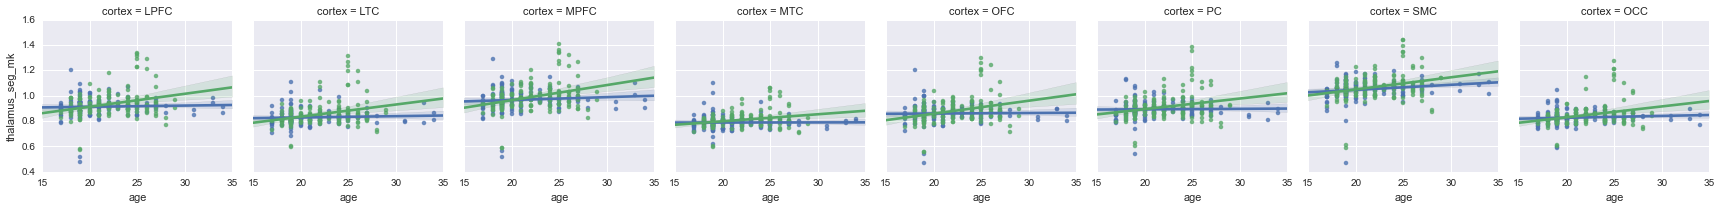

Correlation between age and MK : 90


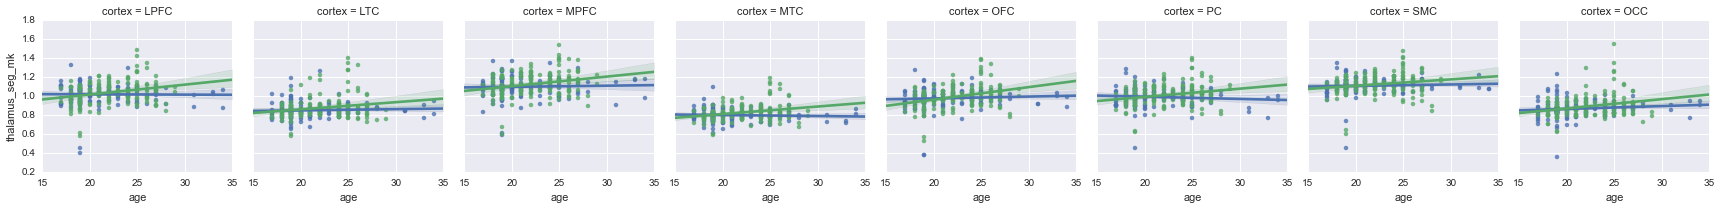

Correlation between age and MK : 95


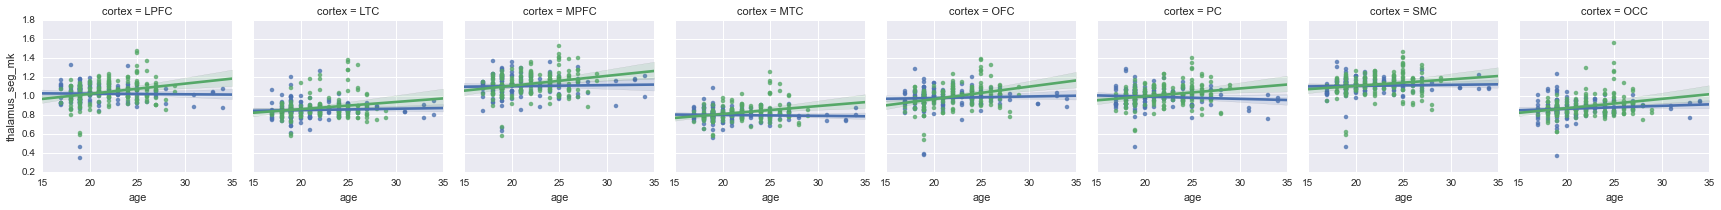

In [120]:
df_gb = df_matched.groupby('threshold')
for thr in '10', '90', '95':
    g = sns.FacetGrid(df_gb.get_group(thr), col='cortex', hue='group')
    g = g.map(sns.regplot, 'age','thalamus_seg_mk')
    print('Correlation between age and MK : '+thr)
    plt.show()

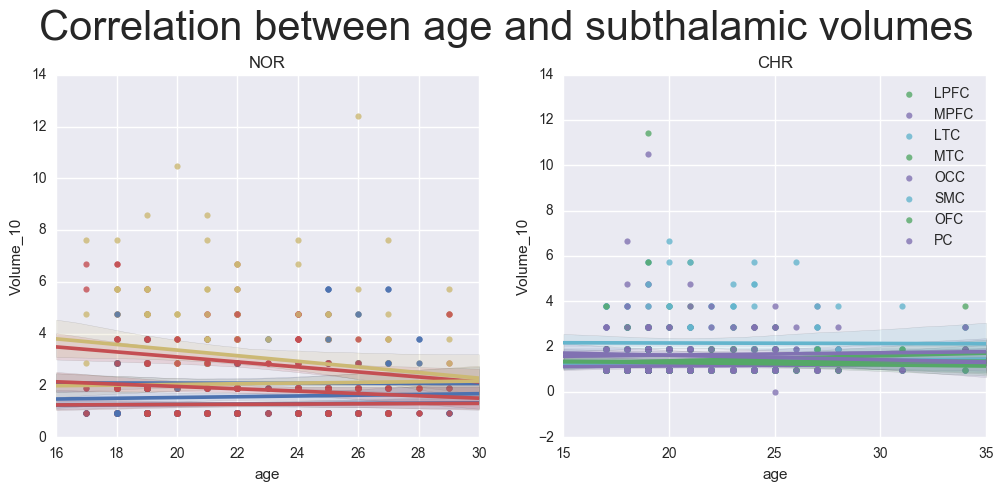

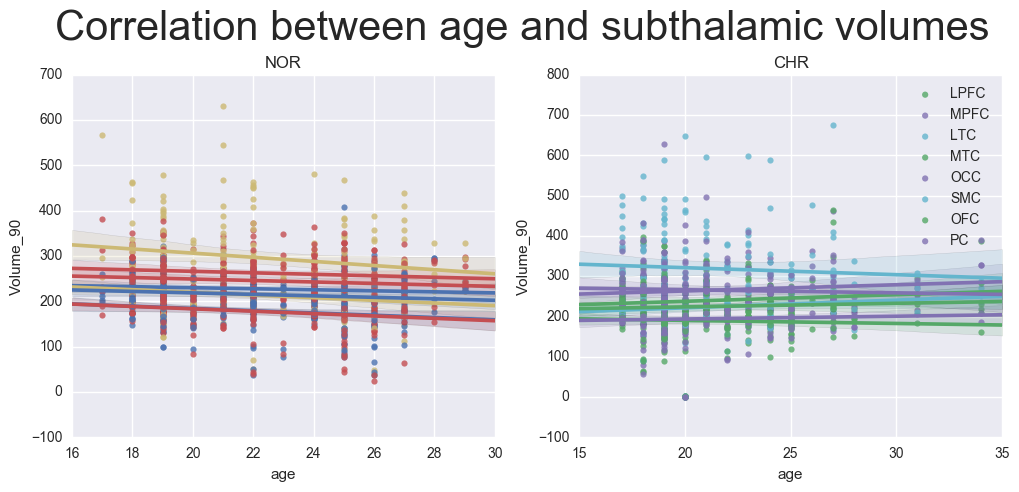

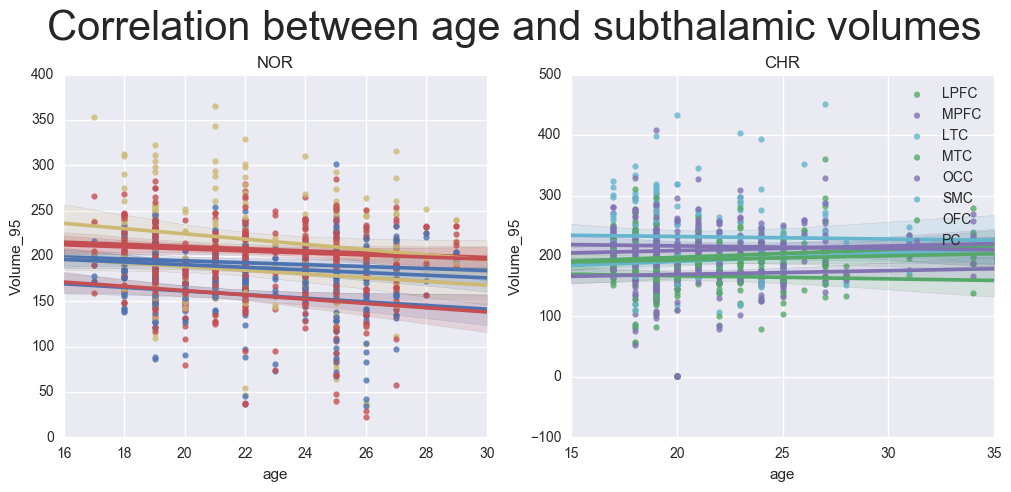

In [170]:
for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(12,5))
    for roi in df_matched.roi.unique():
        sns.regplot('age', 
                    'Volume_'+thr, 
                    df_matched.groupby('Group').get_group('NOR').groupby('roi').get_group(roi),
                    label = roi,
                    ax=axes[0])
        sns.regplot('age', 
                    'Volume_'+thr, 
                    df_matched.groupby('Group').get_group('CHR').groupby('roi').get_group(roi),
                    label = roi,
                    ax=axes[1])
    plt.subplots_adjust(top=0.85)
    axes[0].set_title('NOR')
    axes[1].set_title('CHR')
    fig.suptitle('Correlation between age and subthalamic volumes'.format(thr), fontsize=30)
    plt.legend()
    plt.show()

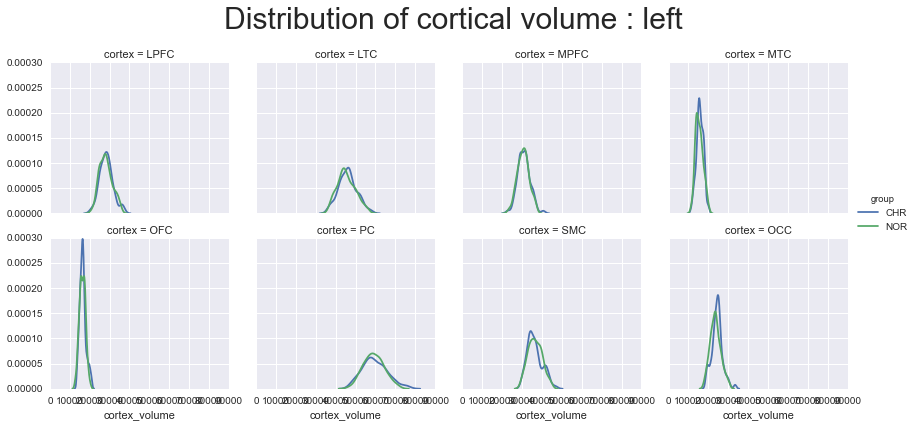

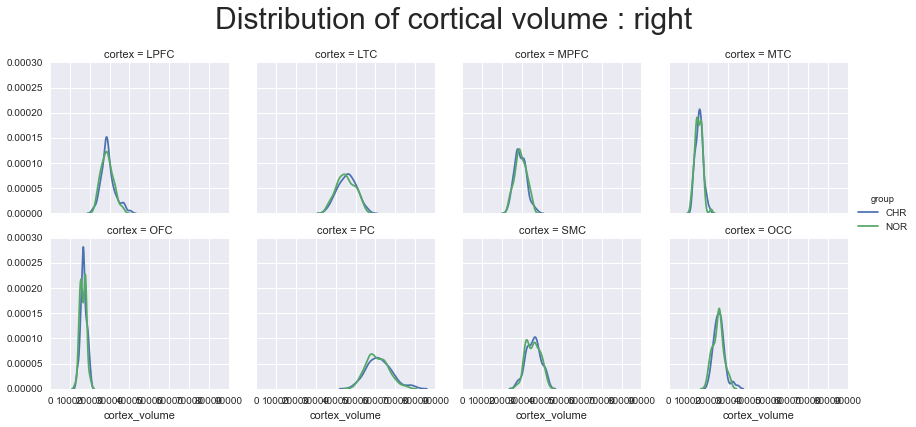

In [122]:
for side in 'left','right':
    g = sns.FacetGrid(df_matched.groupby('side').get_group(side)[['cortex',
                                                                  'thalamus_seg_volume',
                                                                  'side',
                                                                  'group',
                                                                  'cortex_volume']].drop_duplicates(), 
                      col='cortex', col_wrap=4, hue='group')
    g = (g.map(sns.kdeplot, 'cortex_volume')).add_legend()
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('Distribution of cortical volume : '+side, fontsize=30)
    plt.show()

/Users/kangik/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


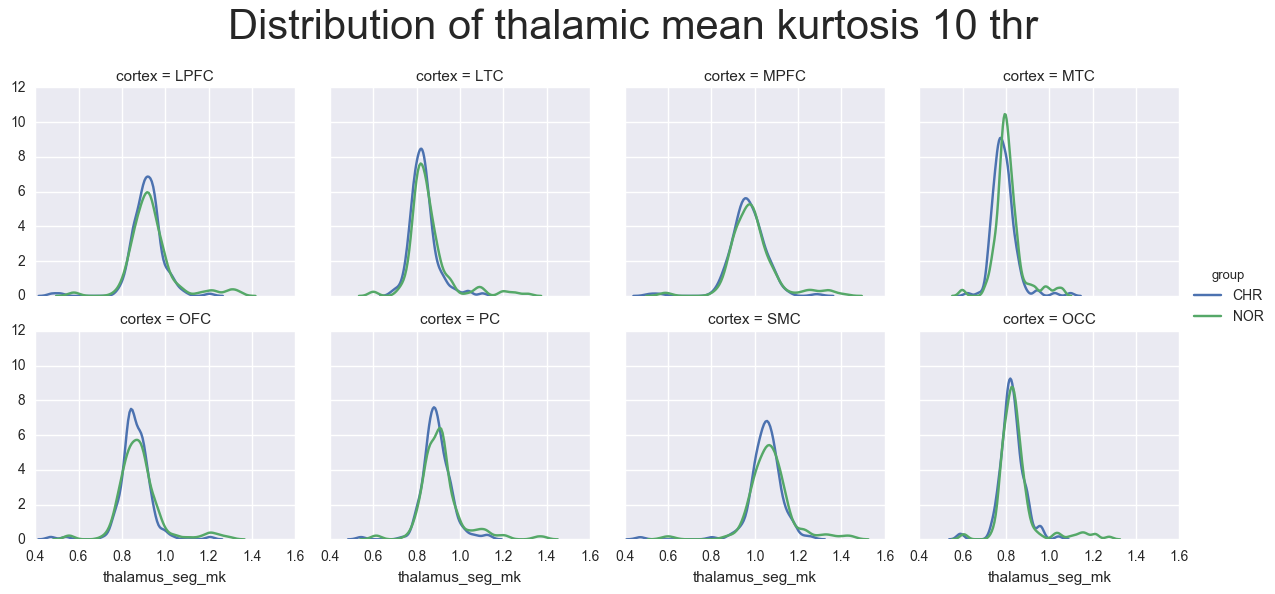

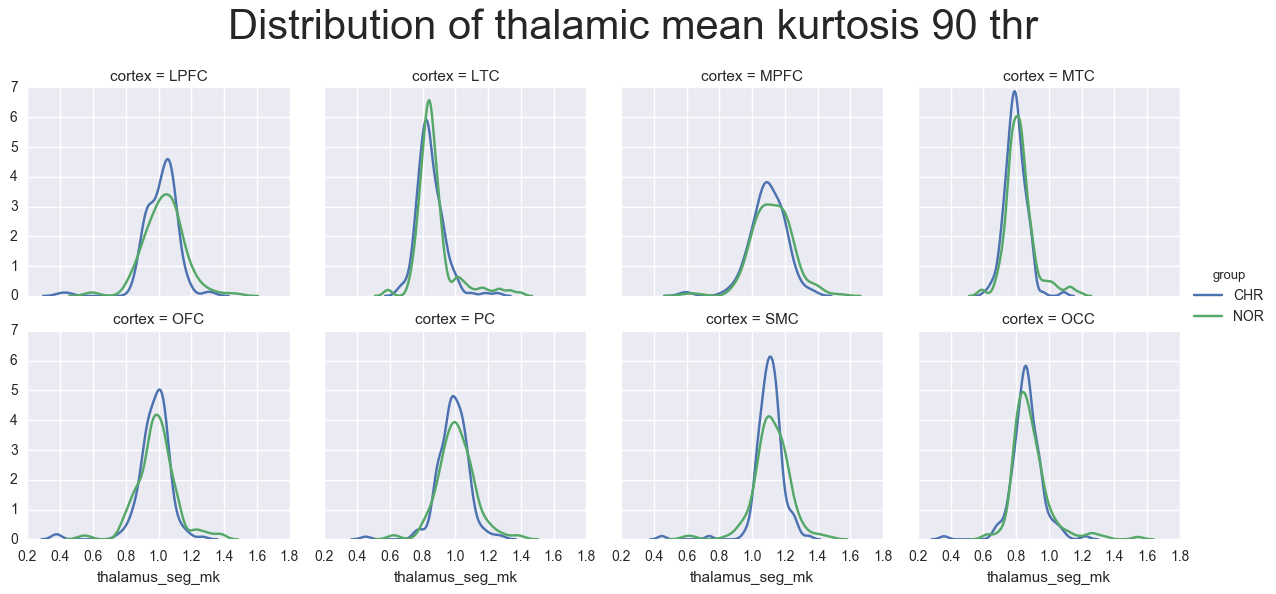

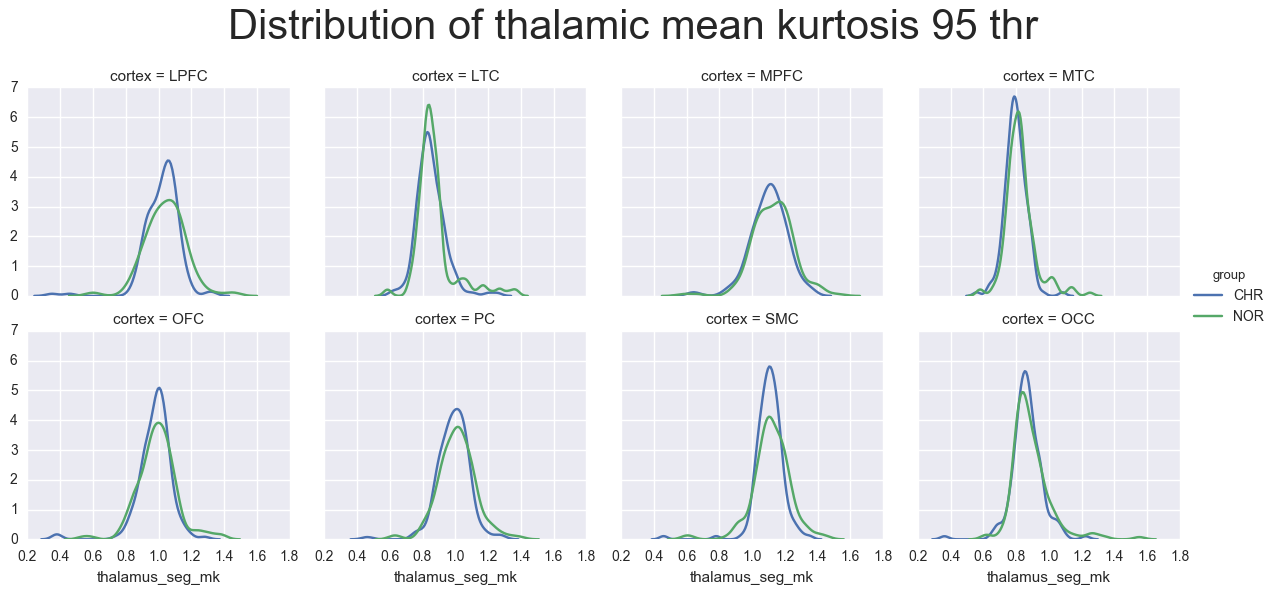

In [73]:
df_gb = df_matched.groupby('threshold')
for thr in '10', '90', '95':
    g = sns.FacetGrid(df_gb.get_group(thr), 
                      col='cortex', col_wrap=4, hue='group')
    g = (g.map(sns.kdeplot, 'thalamus_seg_mk')).add_legend()
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('Distribution of thalamic mean kurtosis {0} thr'.format(thr), fontsize=30)
    plt.show()

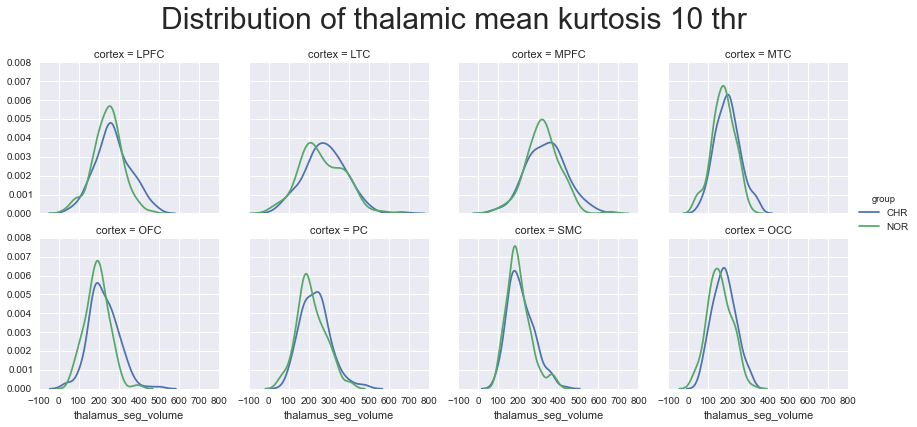

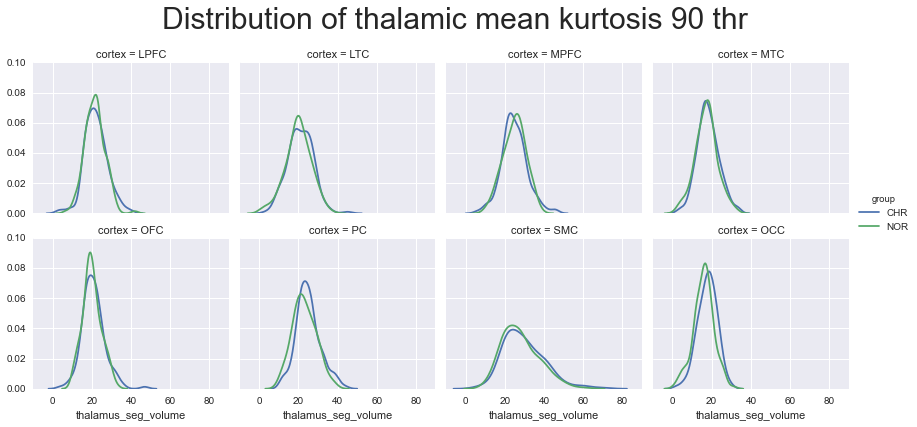

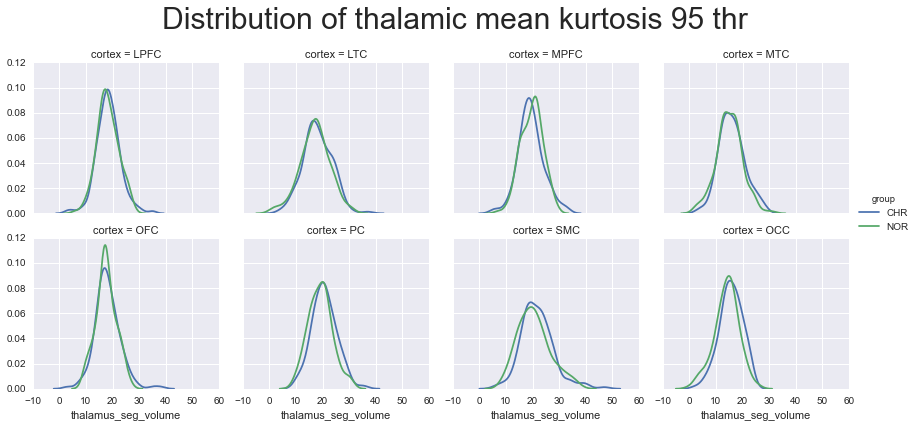

In [124]:
df_gb = df_matched.groupby('threshold')
for thr in '10', '90', '95':
    g = sns.FacetGrid(df_gb.get_group(thr), 
                      col='cortex', col_wrap=4, hue='group')
    g = (g.map(sns.kdeplot, 'thalamus_seg_volume')).add_legend()
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('Distribution of thalamic mean kurtosis {0} thr'.format(thr), fontsize=30)
    plt.show()

---

# 3. Statistics

In [99]:
cortices = df_matched.roi.unique()

## Comparison of thalamic volumes

In [127]:
df_gb = df_matched.groupby(['threshold', 'side','cortex'])
for thr in '10', '90', '95':
    print thr, '='*60
    for side in 'left', 'right':
        print('side', side)
        print('='*80)
        compare = 'thalamus_seg_volume'
        for cortex in cortices:
            x = df_gb.get_group((thr, side, cortex))
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
                print(cortex)
                print(output)
                print()
        print('='*80)
        print()
        print()

10 ============================================================
('side', 'left')
LPFC
           df          sum_sq       mean_sq         F    PR(>F)
GROUP       1    61984.005998  61984.005998  8.319999  0.004499
AGE         1     5173.047458   5173.047458  0.694369  0.406007
SEX         1    14741.186756  14741.186756  1.978682  0.161598
Residual  150  1117500.201346   7450.001342       NaN       NaN
()
LTC
           df          sum_sq       mean_sq         F    PR(>F)
GROUP       1    52490.230401  52490.230401  4.426971  0.037043
AGE         1       33.616666     33.616666  0.002835  0.957606
SEX         1     1151.290846   1151.290846  0.097099  0.755772
Residual  150  1778537.543905  11856.916959       NaN       NaN
()
MTC
           df         sum_sq       mean_sq         F    PR(>F)
GROUP       1   34674.552119  34674.552119  9.773218  0.002127
AGE         1    3467.234290   3467.234290  0.977260  0.324468
SEX         1    3809.907212   3809.907212  1.073844  0.301747
Residual

## Comparison of cortical ROI volumes

In [133]:
df_gb = df_matched.groupby(['side','cortex'])

for side in 'left', 'right':
    print('side', side)
    print('='*80)
    compare = 'cortex_volume'
    for cortex in cortices:
        x = df_gb.get_group((side, cortex))[['subject', 'age', 'group', 'sex', compare]].drop_duplicates()
        GROUP = x['group']
        VAR = x[compare]
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        if output['PR(>F)'].GROUP < 0.05:
            print(cortex)
            print(output)
            print()
    print('='*80)
    print()
    print()

('side', 'left')
()
()
('side', 'right')
()
()


## Thalamic nuclei volume left and right together

In [224]:
df_gb = df_matched.groupby(['threshold', 'side','cortex'])
for thr in '10', '90', '95':
    print thr, '='*60
    for side in 'left', 'right':
        print('side', side)
        print('='*80)
        compare = 'thalamus_seg_volume'
        for cortex in cortices:
            x = df_gb.get_group((thr, side, cortex))
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
                print(cortex)
                print(output)
                print()
        print('='*80)
        print()
        print()

thr 10
LPFC
             df      sum_sq    mean_sq          F        PR(>F)
GROUP       1.0   36.208203  36.208203  36.839270  3.893301e-09
AGE         1.0    0.421348   0.421348   0.428692  5.131366e-01
SEX         1.0    0.049737   0.049737   0.050604  8.221705e-01
Residual  298.0  292.895180   0.982870        NaN           NaN

MPFC
             df      sum_sq     mean_sq          F        PR(>F)
GROUP       1.0  118.226911  118.226911  92.467511  3.053451e-19
AGE         1.0    4.658600    4.658600   3.643579  5.724628e-02
SEX         1.0    0.247526    0.247526   0.193595  6.602604e-01
Residual  298.0  381.016199    1.278578        NaN           NaN

LTC
             df      sum_sq    mean_sq          F        PR(>F)
GROUP       1.0   45.774331  45.774331  48.804488  1.851185e-11
AGE         1.0    0.448150   0.448150   0.477817  4.899511e-01
SEX         1.0    0.002316   0.002316   0.002469  9.604015e-01
Residual  298.0  279.497877   0.937912        NaN           NaN

OCC
       

## Thalamic nuclei volume left and right separately

In [226]:
for thr in '10', '90', '95':
    for side in 'left', 'right':
        print('thr', thr)
        print('side', side)
        print('='*80)
        compare = 'Volume_'+thr
        for cortex in cortices:
            x = df_matched.groupby('roi').get_group(cortex).groupby('side').get_group(side)
            GROUP = x['Group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
                print(cortex)
                print(output)
                print()
        print('='*80)
        print()
        print()

thr 10
side left
LPFC
             df      sum_sq    mean_sq          F    PR(>F)
GROUP       1.0   21.154828  21.154828  17.677226  0.000045
AGE         1.0    0.823121   0.823121   0.687809  0.408255
SEX         1.0    0.987312   0.987312   0.825009  0.365206
Residual  147.0  175.918990   1.196728        NaN       NaN

MPFC
             df      sum_sq    mean_sq          F        PR(>F)
GROUP       1.0   55.478263  55.478263  39.517370  3.501228e-09
AGE         1.0    7.036488   7.036488   5.012116  2.667267e-02
SEX         1.0    0.070073   0.070073   0.049913  8.235250e-01
Residual  147.0  206.372656   1.403896        NaN           NaN

LTC
             df      sum_sq    mean_sq          F        PR(>F)
GROUP       1.0   31.893989  31.893989  28.760062  3.111632e-07
AGE         1.0    0.428597   0.428597   0.386483  5.351169e-01
SEX         1.0    0.013805   0.013805   0.012449  9.113143e-01
Residual  147.0  163.018302   1.108968        NaN           NaN

SMC
             df      s

## Mean kurtosis in thalamic nuclei left and right together

> 10 thrP

In [113]:
df_gb = df_matched.groupby(['threshold', 'side','cortex'])
for thr in '10', '90', '95':
    print(thr, '='*60)
    for side in 'left', 'right':
        print('side', side)
        print('='*80)
        compare = 'thalamus_seg_mk'
        for cortex in cortices:
            x = df_gb.get_group((thr, side, cortex))
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
                print(cortex)
                print(output)
                print()
        print('='*80)
        print()
        print()

10 ============================================================
side left
LTC
             df    sum_sq   mean_sq         F    PR(>F)
GROUP       1.0  0.023865  0.023865  4.234151  0.041350
AGE         1.0  0.033770  0.033770  5.991662  0.015528
SEX         1.0  0.011257  0.011257  1.997217  0.159660
Residual  150.0  0.845432  0.005636       NaN       NaN

MTC
             df    sum_sq   mean_sq         F    PR(>F)
GROUP       1.0  0.017342  0.017342  5.088983  0.025524
AGE         1.0  0.013335  0.013335  3.913129  0.049742
SEX         1.0  0.001487  0.001487  0.436350  0.509902
Residual  150.0  0.511173  0.003408       NaN       NaN



side right
LTC
             df    sum_sq   mean_sq         F    PR(>F)
GROUP       1.0  0.030513  0.030513  3.996371  0.047405
AGE         1.0  0.038334  0.038334  5.020701  0.026515
SEX         1.0  0.047602  0.047602  6.234448  0.013609
Residual  150.0  1.145289  0.007635       NaN       NaN

MTC
             df    sum_sq   mean_sq         F    PR(>F